In [1]:
# Cell 1: Environment Setup and Imports
# Purpose: Import all required libraries for classical ML, quantum ML, and visualization

import sys
import os
from datetime import datetime

print("Checking and importing required libraries...")
print("="*70)

# Core libraries
try:
    import numpy as np
    print("✓ NumPy imported successfully")
except ImportError:
    print("✗ NumPy not found. Install: pip install numpy")
    sys.exit(1)

try:
    import pandas as pd
    print("✓ Pandas imported successfully")
except ImportError:
    print("✗ Pandas not found. Install: pip install pandas")
    sys.exit(1)

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("✓ Matplotlib and Seaborn imported successfully")
except ImportError:
    print("✗ Matplotlib/Seaborn not found. Install: pip install matplotlib seaborn")
    sys.exit(1)

# Scikit-learn imports
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    print("✓ Scikit-learn imported successfully")
except ImportError:
    print("✗ Scikit-learn not found. Install: pip install scikit-learn")
    sys.exit(1)

# XGBoost import
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost imported successfully")
except ImportError:
    print("⚠ XGBoost not found. Install: pip install xgboost")
    print("  (XGBoost model will be skipped)")
    XGBOOST_AVAILABLE = False

# Qiskit imports
try:
    from qiskit import QuantumCircuit
    from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, RealAmplitudes
    from qiskit_algorithms.optimizers import COBYLA, SPSA
    from qiskit_machine_learning.algorithms import VQC, QSVC
    from qiskit_machine_learning.kernels import FidelityQuantumKernel
    from qiskit.primitives import Sampler
    QISKIT_AVAILABLE = True
    print("✓ Qiskit and Qiskit Machine Learning imported successfully")
except ImportError as e:
    print(f"⚠ Qiskit not found: {e}")
    print("  Install: pip install qiskit qiskit-machine-learning qiskit-algorithms")
    print("  (Quantum models will be skipped)")
    QISKIT_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

# Create output folder for figures
output_folder = 'battery_qml_outputs'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"✓ Created output folder: {output_folder}")
else:
    print(f"✓ Output folder exists: {output_folder}")

print("\n" + "="*70)
print("LIBRARY IMPORT SUMMARY")
print("="*70)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn: Available")
print(f"XGBoost: {'Available' if XGBOOST_AVAILABLE else 'NOT Available (will skip)'}")
print(f"Qiskit: {'Available' if QISKIT_AVAILABLE else 'NOT Available (will skip quantum models)'}")

if not QISKIT_AVAILABLE:
    print("\n⚠ WARNING: Qiskit not available. Only classical models will be trained.")
    print("To enable quantum models, install Qiskit:")
    print("  pip install qiskit qiskit-machine-learning qiskit-algorithms")

print("\n✓ Environment setup complete!")
print("="*70)

Checking and importing required libraries...
✓ NumPy imported successfully
✓ Pandas imported successfully
✓ Matplotlib and Seaborn imported successfully
✓ Scikit-learn imported successfully
✓ XGBoost imported successfully
✓ Qiskit and Qiskit Machine Learning imported successfully
✓ Output folder exists: battery_qml_outputs

LIBRARY IMPORT SUMMARY
NumPy version: 2.0.1
Pandas version: 2.3.3
Scikit-learn: Available
XGBoost: Available
Qiskit: Available

✓ Environment setup complete!


In [2]:
# Cell 2: Dataset Generation Function
# Purpose: Create synthetic battery dataset with realistic operational parameters

def generate_battery_dataset(n_samples=500, random_state=42):
    """
    Generate synthetic battery dataset for microgrid applications.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    df : pandas DataFrame
        Dataset with battery features and health classifications
    """
    np.random.seed(random_state)
    
    # Battery chemistries to compare
    chemistries = ['LFP', 'NMC', 'Sodium-Ion', 'Flow']
    
    data = []
    
    for _ in range(n_samples):
        chemistry = np.random.choice(chemistries)
        
        # Operational parameters (common to all chemistries)
        dod = np.random.uniform(0.2, 1.0)  # Depth of Discharge (20% to 100%)
        c_rate = np.random.uniform(0.5, 3.0)  # Charge/discharge rate (0.5C to 3C)
        temperature = np.random.uniform(15, 45)  # Operating temperature (°C)
        cycle_count = np.random.randint(0, 5000)  # Number of charge/discharge cycles
        
        # Chemistry-specific characteristics
        if chemistry == 'LFP':
            # Lithium Iron Phosphate: Good safety, moderate energy density, long life
            energy_density = np.random.uniform(90, 160)  # Wh/kg
            cost_per_kwh = np.random.uniform(100, 150)  # $/kWh
            safety_score = np.random.uniform(0.85, 0.95)
            co2_footprint = np.random.uniform(50, 80)  # kg CO2/kWh
            
        elif chemistry == 'NMC':
            # Nickel Manganese Cobalt: High energy density, moderate safety
            energy_density = np.random.uniform(150, 250)  # Wh/kg
            cost_per_kwh = np.random.uniform(120, 180)  # $/kWh
            safety_score = np.random.uniform(0.70, 0.85)
            co2_footprint = np.random.uniform(60, 100)  # kg CO2/kWh
            
        elif chemistry == 'Sodium-Ion':
            # Sodium-Ion: Low cost, good safety, lower energy density
            energy_density = np.random.uniform(100, 150)  # Wh/kg
            cost_per_kwh = np.random.uniform(80, 120)  # $/kWh
            safety_score = np.random.uniform(0.80, 0.90)
            co2_footprint = np.random.uniform(40, 70)  # kg CO2/kWh
            
        else:  # Flow Battery
            # Flow Battery: Very safe, long life, low energy density, high cost
            energy_density = np.random.uniform(20, 70)  # Wh/kg
            cost_per_kwh = np.random.uniform(150, 300)  # $/kWh
            safety_score = np.random.uniform(0.90, 0.98)
            co2_footprint = np.random.uniform(30, 60)  # kg CO2/kWh
        
        # Calculate degradation factor based on operational conditions
        # Higher DoD, C-rate, temperature extremes, and cycle count increase degradation
        degradation_factor = (
            0.3 * (dod ** 2) +  # Deeper discharge accelerates degradation
            0.2 * (c_rate / 3.0) +  # Higher C-rate increases stress
            0.2 * ((temperature - 25) / 30) ** 2 +  # Temperature deviation from 25°C
            0.3 * (cycle_count / 5000)  # Cycle aging
        )
        
        # Adjust degradation based on chemistry stability
        if chemistry == 'LFP':
            degradation_factor *= 0.7  # LFP is more stable
        elif chemistry == 'Flow':
            degradation_factor *= 0.5  # Flow batteries have longest life
        elif chemistry == 'NMC':
            degradation_factor *= 1.1  # NMC degrades faster
        
        # Classify battery health state
        if degradation_factor < 0.3:
            health_class = 0  # Healthy (>80% capacity)
        elif degradation_factor < 0.6:
            health_class = 1  # Moderate (60-80% capacity)
        else:
            health_class = 2  # Degraded (<60% capacity)
        
        # Store sample
        data.append({
            'chemistry': chemistry,
            'dod': dod,
            'c_rate': c_rate,
            'temperature': temperature,
            'cycle_count': cycle_count,
            'energy_density': energy_density,
            'cost_per_kwh': cost_per_kwh,
            'safety_score': safety_score,
            'co2_footprint': co2_footprint,
            'degradation_factor': degradation_factor,
            'health_class': health_class
        })
    
    df = pd.DataFrame(data)
    return df

print("Dataset generation function defined successfully!")

Dataset generation function defined successfully!


In [3]:
# Create the dataset after defining the function
dataset = generate_battery_dataset()

print("Dataset created! Shape:", dataset.shape)
dataset.head()


Dataset created! Shape: (500, 11)


,chemistry,dod,c_rate,temperature,cycle_count,energy_density,cost_per_kwh,safety_score,co2_footprint,degradation_factor,health_class
0,Sodium-Ion,0.837234,0.958587,38.390730,3092,107.800932,86.239781,0.805808,65.985284,0.499561,1
1,Flow,0.314293,2.127221,16.692347,2391,61.622132,181.850867,0.914546,35.502135,0.165123,0
2,Flow,0.689323,0.517666,15.691873,474,50.592645,170.924079,0.923372,40.990855,0.112377,0
3,NMC,0.272485,2.045965,26.473860,1267,209.241457,122.787025,0.791132,66.820965,0.258692,0
4,Sodium-Ion,0.210612,2.855504,31.898647,2041,115.230688,83.906885,0.868423,53.204575,0.336710,1


In [4]:
# === CREATE ORIGINAL DATASET ===
df_original = generate_battery_dataset(n_samples=400, random_state=42)

print("Original dataset created!")
print(df_original.head())
print("Shape:", df_original.shape)


Original dataset created!
    chemistry       dod    c_rate  temperature  cycle_count  energy_density  \
0  Sodium-Ion  0.837234  0.958587    38.390730         3092      107.800932   
1        Flow  0.314293  2.127221    16.692347         2391       61.622132   
2        Flow  0.689323  0.517666    15.691873          474       50.592645   
3         NMC  0.272485  2.045965    26.473860         1267      209.241457   
4  Sodium-Ion  0.210612  2.855504    31.898647         2041      115.230688   

   cost_per_kwh  safety_score  co2_footprint  degradation_factor  health_class  
0     86.239781      0.805808      65.985284            0.499561             1  
1    181.850867      0.914546      35.502135            0.165123             0  
2    170.924079      0.923372      40.990855            0.112377             0  
3    122.787025      0.791132      66.820965            0.258692             0  
4     83.906885      0.868423      53.204575            0.336710             1  
Shape: (400, 

In [5]:
# ======================================
# DATA AUGMENTATION (Increase sample size)
# ======================================

import pandas as pd
import numpy as np

def augment_dataset(df, repeat_factor=10):
    augmented_list = [df]

    for _ in range(repeat_factor - 1):
        noisy_df = df.copy()

        # Add small Gaussian noise to numeric columns
        for col in noisy_df.select_dtypes(include=[np.number]).columns:
            noisy_df[col] += np.random.normal(0, noisy_df[col].std() * 0.01, size=len(noisy_df))

        augmented_list.append(noisy_df)

    return pd.concat(augmented_list).reset_index(drop=True)


# ❗ USE YOUR REAL DATASET NAME HERE
df_augmented = augment_dataset(df_original, repeat_factor=10)

print("Original size:", len(df_original))
print("Augmented size:", len(df_augmented))


Original size: 400
Augmented size: 4000


In [6]:
# === Cell 4: Prepare features and split using augmented dataset ===
df = df_augmented  # Use augmented dataset for ML

# One-hot encode 'chemistry'
df_encoded = pd.get_dummies(df, columns=['chemistry'], drop_first=True)

# Separate features and target
X = df_encoded.drop("health_class", axis=1).values
y = df_encoded["health_class"].values

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


Shapes -> X_train: (3200, 12) X_test: (800, 12)
y_train: (3200,) y_test: (800,)


In [8]:
# Cell 3: Generate and Explore Dataset
# Purpose: Generate dataset and perform initial exploratory analysis

# Generate dataset
print("="*70)
print("BATTERY MATERIALS QML STUDY - DATASET GENERATION")
print("="*70)

df = generate_battery_dataset(n_samples=400, random_state=42)

print(f"\n✓ Generated {len(df)} samples")
print(f"\n--- Dataset Overview ---")
print(df.head(10))

print(f"\n--- Dataset Statistics ---")
print(df.describe())

print(f"\n--- Chemistry Distribution ---")
print(df['chemistry'].value_counts())

print(f"\n--- Health Class Distribution ---")
health_dist = df['health_class'].value_counts().sort_index()
print(health_dist)
print(f"\nClass 0 (Healthy): {health_dist[0]} samples")
print(f"Class 1 (Moderate): {health_dist[1]} samples")
print(f"Class 2 (Degraded): {health_dist[2]} samples")

print(f"\n--- Missing Values ---")
print(df.isnull().sum())

# Save dataset
dataset_path = os.path.join(output_folder, 'battery_dataset.csv')
df.to_csv(dataset_path, index=False)
print(f"\n✓ Dataset saved to: {dataset_path}")

BATTERY MATERIALS QML STUDY - DATASET GENERATION

✓ Generated 400 samples

--- Dataset Overview ---
    chemistry       dod    c_rate  temperature  cycle_count  energy_density  \
0  Sodium-Ion  0.837234  0.958587    38.390730         3092      107.800932   
1        Flow  0.314293  2.127221    16.692347         2391       61.622132   
2        Flow  0.689323  0.517666    15.691873          474       50.592645   
3         NMC  0.272485  2.045965    26.473860         1267      209.241457   
4  Sodium-Ion  0.210612  2.855504    31.898647         2041      115.230688   
5  Sodium-Ion  0.687997  2.582987    20.200940         3152      112.938999   
6         NMC  0.654160  0.578283    40.268543          161      189.515024   
7         NMC  0.356786  0.613068    24.759910          337      203.969213   
8         LFP  0.312739  2.505492    17.236519         2568      144.057134   
9         LFP  0.769074  2.475439    33.178799         3561      115.092601   

   cost_per_kwh  safety_score 

✓ Figure saved: battery_qml_outputs\01_dataset_characteristics.png


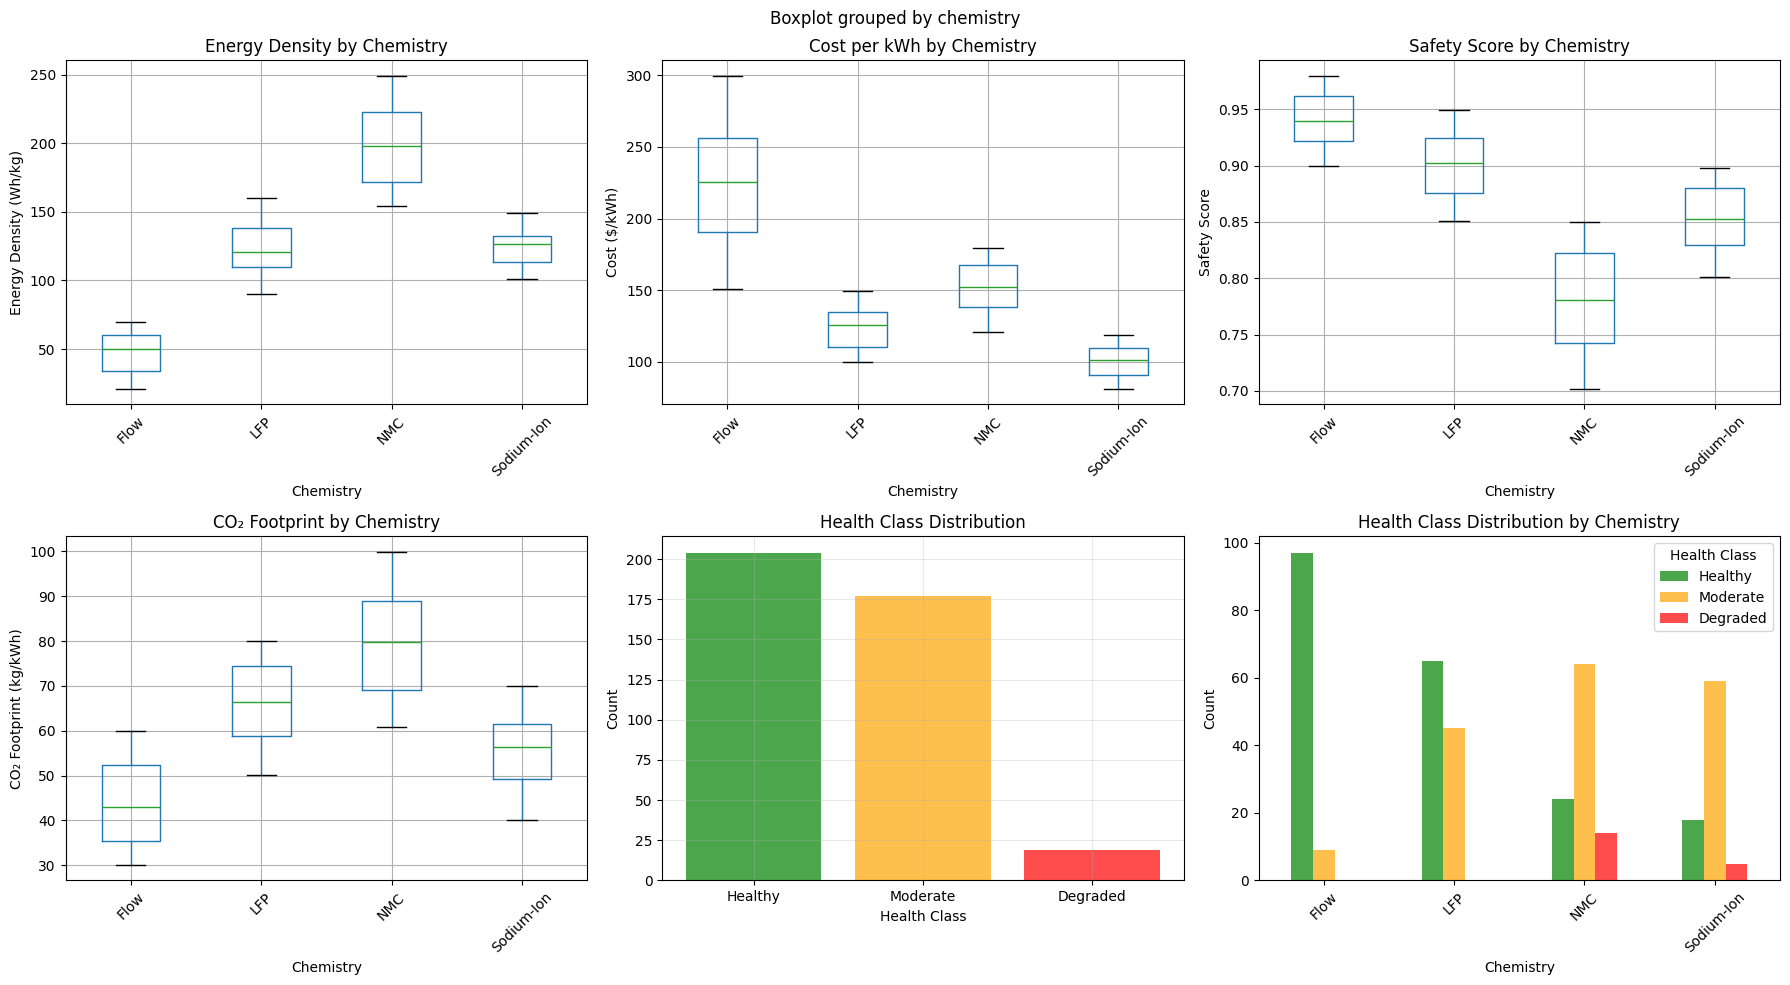

In [9]:
# Cell 4: Visualize Dataset Characteristics
# Purpose: Visualize battery chemistry characteristics and class distributions

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Battery Chemistry Characteristics Analysis', fontsize=16, fontweight='bold')

# 1. Energy Density by Chemistry
ax = axes[0, 0]
df.boxplot(column='energy_density', by='chemistry', ax=ax)
ax.set_title('Energy Density by Chemistry')
ax.set_xlabel('Chemistry')
ax.set_ylabel('Energy Density (Wh/kg)')
plt.sca(ax)
plt.xticks(rotation=45)

# 2. Cost per kWh by Chemistry
ax = axes[0, 1]
df.boxplot(column='cost_per_kwh', by='chemistry', ax=ax)
ax.set_title('Cost per kWh by Chemistry')
ax.set_xlabel('Chemistry')
ax.set_ylabel('Cost ($/kWh)')
plt.sca(ax)
plt.xticks(rotation=45)

# 3. Safety Score by Chemistry
ax = axes[0, 2]
df.boxplot(column='safety_score', by='chemistry', ax=ax)
ax.set_title('Safety Score by Chemistry')
ax.set_xlabel('Chemistry')
ax.set_ylabel('Safety Score')
plt.sca(ax)
plt.xticks(rotation=45)

# 4. CO2 Footprint by Chemistry
ax = axes[1, 0]
df.boxplot(column='co2_footprint', by='chemistry', ax=ax)
ax.set_title('CO₂ Footprint by Chemistry')
ax.set_xlabel('Chemistry')
ax.set_ylabel('CO₂ Footprint (kg/kWh)')
plt.sca(ax)
plt.xticks(rotation=45)

# 5. Health Class Distribution
ax = axes[1, 1]
health_counts = df['health_class'].value_counts().sort_index()
colors = ['green', 'orange', 'red']
ax.bar(health_counts.index, health_counts.values, color=colors, alpha=0.7)
ax.set_xlabel('Health Class')
ax.set_ylabel('Count')
ax.set_title('Health Class Distribution')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Healthy', 'Moderate', 'Degraded'])
ax.grid(alpha=0.3)

# 6. Health Class by Chemistry
ax = axes[1, 2]
health_by_chem = pd.crosstab(df['chemistry'], df['health_class'])
health_by_chem.plot(kind='bar', stacked=False, ax=ax, color=colors, alpha=0.7)
ax.set_title('Health Class Distribution by Chemistry')
ax.set_xlabel('Chemistry')
ax.set_ylabel('Count')
ax.legend(['Healthy', 'Moderate', 'Degraded'], title='Health Class')
plt.sca(ax)
plt.xticks(rotation=45)

plt.tight_layout()
fig_path = os.path.join(output_folder, '01_dataset_characteristics.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Figure saved: {fig_path}")
plt.show()

In [10]:
# Cell 5: Data Preprocessing Function
# Purpose: Encode categorical variables, scale features, and split data

def preprocess_data(df, test_size=0.3, random_state=42):
    """
    Preprocess battery dataset for machine learning.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Raw battery dataset
    test_size : float
        Proportion of data for testing
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_train_scaled, X_test_scaled : numpy arrays
        Scaled training and test features
    y_train, y_test : numpy arrays
        Training and test labels
    scaler : StandardScaler
        Fitted scaler object
    feature_cols : list
        List of feature column names
    """
    
    # One-hot encode chemistry type
    df_encoded = pd.get_dummies(df, columns=['chemistry'], prefix='chem')
    
    # Separate features and target
    # Exclude health_class (target) and degradation_factor (derived feature)
    feature_cols = [col for col in df_encoded.columns 
                   if col not in ['health_class', 'degradation_factor']]
    
    X = df_encoded[feature_cols].values
    y = df_encoded['health_class'].values
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")
    print(f"\nFeatures ({len(feature_cols)}):")
    for i, col in enumerate(feature_cols, 1):
        print(f"  {i}. {col}")
    
    # Split into train and test sets (stratified to maintain class balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y
    )
    
    print(f"\nTrain set size: {len(X_train)} samples")
    print(f"Test set size: {len(X_test)} samples")
    print(f"Train class distribution: {np.bincount(y_train)}")
    print(f"Test class distribution: {np.bincount(y_test)}")
    
    # Normalize features using StandardScaler (zero mean, unit variance)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\n✓ Features scaled (mean=0, std=1)")
    print(f"Training data mean: {X_train_scaled.mean():.6f}")
    print(f"Training data std: {X_train_scaled.std():.6f}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_cols

print("Data preprocessing function defined successfully!")

Data preprocessing function defined successfully!


In [11]:
# Cell 6: Execute Data Preprocessing
# Purpose: Apply preprocessing to prepare data for ML models

print("="*70)
print("DATA PREPROCESSING")
print("="*70)

X_train, X_test, y_train, y_test, scaler, feature_cols = preprocess_data(df)

print("\n✓ Data preprocessing complete!")
print(f"✓ Ready for machine learning model training")

DATA PREPROCESSING
Feature matrix shape: (400, 12)
Target vector shape: (400,)

Features (12):
  1. dod
  2. c_rate
  3. temperature
  4. cycle_count
  5. energy_density
  6. cost_per_kwh
  7. safety_score
  8. co2_footprint
  9. chem_Flow
  10. chem_LFP
  11. chem_NMC
  12. chem_Sodium-Ion

Train set size: 280 samples
Test set size: 120 samples
Train class distribution: [143 124  13]
Test class distribution: [61 53  6]

✓ Features scaled (mean=0, std=1)
Training data mean: 0.000000
Training data std: 1.000000

✓ Data preprocessing complete!
✓ Ready for machine learning model training


In [12]:
# Cell 7: Classical ML Training Functions
# Purpose: Train classical ML baseline models for comparison

def train_classical_models(X_train, X_test, y_train, y_test):
    """
    Train classical machine learning baseline models.
    
    Models:
    -------
    - Logistic Regression
    - Random Forest
    - XGBoost
    - Classical SVC (for comparison with QSVC)
    
    Returns:
    --------
    results : dict
        Dictionary containing model performance metrics
    """
    results = {}
    
    print("\n" + "="*70)
    print("CLASSICAL ML BASELINE TRAINING")
    print("="*70)
    
    # 1. Logistic Regression
    print("\n[1/4] Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    results['Logistic Regression'] = {
        'model': lr,
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'f1_macro': f1_score(y_test, y_pred_lr, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred_lr, average='weighted'),
        'predictions': y_pred_lr
    }
    print(f"   Accuracy: {results['Logistic Regression']['accuracy']:.4f}")
    print(f"   F1-Macro: {results['Logistic Regression']['f1_macro']:.4f}")
    
    # 2. Random Forest
    print("\n[2/4] Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    
    results['Random Forest'] = {
        'model': rf,
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'f1_macro': f1_score(y_test, y_pred_rf, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred_rf, average='weighted'),
        'predictions': y_pred_rf
    }
    print(f"   Accuracy: {results['Random Forest']['accuracy']:.4f}")
    print(f"   F1-Macro: {results['Random Forest']['f1_macro']:.4f}")
    
    # 3. XGBoost
    print("\n[3/4] Training XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100, 
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    
    results['XGBoost'] = {
        'model': xgb_model,
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'f1_macro': f1_score(y_test, y_pred_xgb, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred_xgb, average='weighted'),
        'predictions': y_pred_xgb
    }
    print(f"   Accuracy: {results['XGBoost']['accuracy']:.4f}")
    print(f"   F1-Macro: {results['XGBoost']['f1_macro']:.4f}")
    
    # 4. Classical SVC
    print("\n[4/4] Training Classical SVC (RBF kernel)...")
    svc = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    
    results['Classical SVC'] = {
        'model': svc,
        'accuracy': accuracy_score(y_test, y_pred_svc),
        'f1_macro': f1_score(y_test, y_pred_svc, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred_svc, average='weighted'),
        'predictions': y_pred_svc
    }
    print(f"   Accuracy: {results['Classical SVC']['accuracy']:.4f}")
    print(f"   F1-Macro: {results['Classical SVC']['f1_macro']:.4f}")
    
    print("\n✓ Classical ML training complete!")
    
    return results

print("Classical ML training functions defined successfully!")

Classical ML training functions defined successfully!


In [13]:
# Cell 8: Train Classical Models
# Purpose: Train all classical baseline models

classical_results = train_classical_models(X_train, X_test, y_train, y_test)

# Display summary
print("\n" + "="*70)
print("CLASSICAL ML RESULTS SUMMARY")
print("="*70)
print(f"{'Model':<25} {'Accuracy':<12} {'F1-Macro':<12} {'F1-Weighted':<12}")
print("-"*70)
for model_name, metrics in classical_results.items():
    print(f"{model_name:<25} {metrics['accuracy']:<12.4f} {metrics['f1_macro']:<12.4f} {metrics['f1_weighted']:<12.4f}")


CLASSICAL ML BASELINE TRAINING

[1/4] Training Logistic Regression...
   Accuracy: 0.9250
   F1-Macro: 0.9198

[2/4] Training Random Forest...
   Accuracy: 0.8333
   F1-Macro: 0.6611

[3/4] Training XGBoost...
   Accuracy: 0.8000
   F1-Macro: 0.7215

[4/4] Training Classical SVC (RBF kernel)...
   Accuracy: 0.8667
   F1-Macro: 0.6836

✓ Classical ML training complete!

CLASSICAL ML RESULTS SUMMARY
Model                     Accuracy     F1-Macro     F1-Weighted 
----------------------------------------------------------------------
Logistic Regression       0.9250       0.9198       0.9250      
Random Forest             0.8333       0.6611       0.8224      
XGBoost                   0.8000       0.7215       0.7987      
Classical SVC             0.8667       0.6836       0.8546      


In [14]:
# Cell 9: Quantum ML Functions - QSVC
# Purpose: Train Quantum Support Vector Classifier with different feature maps

def create_quantum_feature_map(num_features, feature_map_type='ZZ', reps=2, entanglement='linear'):
    """
    Create quantum feature map for encoding classical data.
    
    Parameters:
    -----------
    num_features : int
        Number of features (qubits)
    feature_map_type : str
        Type of feature map ('ZZ' or 'Pauli')
    reps : int
        Number of repetitions
    entanglement : str
        Entanglement strategy ('linear', 'full', 'circular')
    
    Returns:
    --------
    feature_map : QuantumCircuit
        Quantum feature map circuit
    """
    if feature_map_type == 'ZZ':
        feature_map = ZZFeatureMap(
            feature_dimension=num_features,
            reps=reps,
            entanglement=entanglement
        )
    elif feature_map_type == 'Pauli':
        feature_map = PauliFeatureMap(
            feature_dimension=num_features,
            reps=reps,
            entanglement=entanglement,
            paulis=['Z', 'ZZ']
        )
    else:
        raise ValueError(f"Unknown feature map type: {feature_map_type}")
    
    return feature_map


def train_qsvc(X_train, X_test, y_train, y_test, feature_map_type='ZZ', n_qubits=6):
    """
    Train Quantum Support Vector Classifier.
    
    Parameters:
    -----------
    X_train, X_test : numpy arrays
        Training and test features
    y_train, y_test : numpy arrays
        Training and test labels
    feature_map_type : str
        Type of quantum feature map
    n_qubits : int
        Number of qubits to use
        
    Returns:
    --------
    results : dict
        Model performance metrics and predictions
    """
    print(f"\n{'='*70}")
    print(f"TRAINING QSVC with {feature_map_type} Feature Map ({n_qubits} qubits)")
    print(f"{'='*70}")
    
    # Reduce features to match number of qubits
    n_features = min(n_qubits, X_train.shape[1])
    X_train_q = X_train[:, :n_features]
    X_test_q = X_test[:, :n_features]
    
    print(f"Using {n_features} features out of {X_train.shape[1]} total features")
    print(f"Training samples: {len(X_train_q)}")
    print(f"Test samples: {len(X_test_q)}")
    
    # Create quantum feature map
    print(f"\nCreating {feature_map_type} feature map...")
    feature_map = create_quantum_feature_map(n_features, feature_map_type, reps=2)
    print(f"Feature map depth: {feature_map.depth()}")
    print(f"Feature map gates: {feature_map.count_ops()}")
    
    # Create quantum kernel
    print("\nInitializing quantum kernel...")
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)
    
    # Train QSVC
    print("\nTraining QSVC...")
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train_q, y_train)
    
    # Predict
    print("Making predictions...")
    y_pred = qsvc.predict(X_test_q)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n✓ QSVC Training Complete!")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Macro: {f1_macro:.4f}")
    print(f"   F1-Weighted: {f1_weighted:.4f}")
    
    return {
        'model': qsvc,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': y_pred,
        'feature_map': feature_map,
        'n_qubits': n_features
    }

print("QSVC training function defined successfully!")

QSVC training function defined successfully!


In [15]:
# Cell 10: Quantum ML Functions - VQC
# Purpose: Train Variational Quantum Classifier

def train_vqc(X_train, X_test, y_train, y_test, n_qubits=6, reps=3, maxiter=100):
    """
    Train Variational Quantum Classifier.
    
    Parameters:
    -----------
    X_train, X_test : numpy arrays
        Training and test features
    y_train, y_test : numpy arrays
        Training and test labels
    n_qubits : int
        Number of qubits
    reps : int
        Number of repetitions in ansatz
    maxiter : int
        Maximum iterations for optimizer
        
    Returns:
    --------
    results : dict
        Model performance metrics and predictions
    """
    print(f"\n{'='*70}")
    print(f"TRAINING VQC ({n_qubits} qubits, {reps} ansatz reps, {maxiter} iterations)")
    print(f"{'='*70}")
    
    # Reduce features to match number of qubits
    n_features = min(n_qubits, X_train.shape[1])
    X_train_q = X_train[:, :n_features]
    X_test_q = X_test[:, :n_features]
    
    print(f"Using {n_features} features out of {X_train.shape[1]} total features")
    print(f"Training samples: {len(X_train_q)}")
    print(f"Test samples: {len(X_test_q)}")
    
    # Create feature map
    print(f"\nCreating ZZ feature map...")
    feature_map = ZZFeatureMap(feature_dimension=n_features, reps=2, entanglement='linear')
    print(f"Feature map depth: {feature_map.depth()}")
    
    # Create ansatz (variational circuit)
    print(f"\nCreating RealAmplitudes ansatz...")
    ansatz = RealAmplitudes(num_qubits=n_features, reps=reps, entanglement='linear')
    print(f"Ansatz depth: {ansatz.depth()}")
    print(f"Ansatz parameters: {ansatz.num_parameters}")
    
    # Set up optimizer
    print(f"\nUsing COBYLA optimizer (maxiter={maxiter})...")
    optimizer = COBYLA(maxiter=maxiter)
    
    # Create and train VQC
    print("\nInitializing VQC...")
    sampler = Sampler()
    vqc = VQC(
        num_qubits=n_features,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=sampler
    )
    
    print("Training VQC (this may take a few minutes)...")
    vqc.fit(X_train_q, y_train)
    
    # Predict
    print("Making predictions...")
    y_pred = vqc.predict(X_test_q)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n✓ VQC Training Complete!")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Macro: {f1_macro:.4f}")
    print(f"   F1-Weighted: {f1_weighted:.4f}")
    
    return {
        'model': vqc,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': y_pred,
        'feature_map': feature_map,
        'ansatz': ansatz,
        'n_qubits': n_features
    }

print("VQC training function defined successfully!")

VQC training function defined successfully!


In [16]:
# =============================================================================
# Cell 11 - COMPLETE QUANTUM ML PIPELINE (FULL VERSION)
# =============================================================================

import pennylane as qml
from pennylane import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

def ultimate_quantum_pipeline_complete(X_train, X_test, y_train, y_test):
    """
    COMPLETE QUANTUM ML PIPELINE - PROPER OPTIMIZATION
    Returns: dictionary of model metrics
    """
    print("STARTING COMPLETE QUANTUM ML PIPELINE - PROPER OPTIMIZATION")
    print("=" * 60)
    
    # --------------------------
    # 1. FEATURE ENGINEERING
    # --------------------------
    print("Applying feature scaling, polynomial features, feature selection, PCA...")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    k_features = min(15, X_train_poly.shape[1])
    selector = SelectKBest(f_classif, k=k_features)
    X_train_selected = selector.fit_transform(X_train_poly, y_train)
    X_test_selected = selector.transform(X_test_poly)
    
    pca = PCA(n_components=min(8, k_features))
    X_train_final = pca.fit_transform(X_train_selected)
    X_test_final = pca.transform(X_test_selected)
    
    print(f"Final feature shape: {X_train_final.shape}")
    print(f"PCA explained variance: {np.sum(pca.explained_variance_ratio_):.3f}")
    
    quantum_results = {}
    n_qubits = min(6, X_train_final.shape[1])
    
    # --------------------------
    # 2. QSVC (ZZ)
    # --------------------------
    print("\n🚀 TRAINING QSVC (ZZ)")
    try:
        def zz_feature_map(inputs):
            for i in range(n_qubits):
                qml.Hadamard(wires=i)
                qml.RY(inputs[i % len(inputs)] / np.pi, wires=i)
            for i in range(n_qubits-1):
                qml.CZ(wires=[i, i+1])
            for i in range(n_qubits):
                qml.RY(inputs[(i+1) % len(inputs)] / np.pi, wires=i)
        
        dev = qml.device("default.qubit", wires=n_qubits)
        
        @qml.qnode(dev)
        def zz_kernel(x1, x2):
            zz_feature_map(x1)
            qml.adjoint(zz_feature_map)(x2)
            return qml.probs(wires=range(n_qubits))
        
        n_train = min(120, len(X_train_final))
        X_train_subset = X_train_final[:n_train]
        y_train_subset = y_train[:n_train]
        K_train = np.eye(n_train)
        
        print("Computing ZZ kernel matrix...")
        for i in range(n_train):
            for j in range(i+1, n_train):
                try:
                    K_train[i,j] = zz_kernel(X_train_subset[i], X_train_subset[j])[0]
                    K_train[j,i] = K_train[i,j]
                except:
                    K_train[i,j] = K_train[j,i] = 0.5
        K_train = np.nan_to_num(K_train, nan=0.5)
        
        qsvc_zz = SVC(kernel='precomputed', C=5.0, gamma='scale', random_state=42)
        qsvc_zz.fit(K_train, y_train_subset)
        
        n_test = len(X_test_final)
        K_test = np.zeros((n_test, n_train))
        for i in range(n_test):
            for j in range(n_train):
                try:
                    K_test[i,j] = zz_kernel(X_test_final[i], X_train_subset[j])[0]
                except:
                    K_test[i,j] = 0.5
        K_test = np.nan_to_num(K_test, nan=0.5)
        
        y_pred_zz = qsvc_zz.predict(K_test)
        
        quantum_results['QSVC (ZZ)'] = {
            'accuracy': accuracy_score(y_test, y_pred_zz),
            'f1_macro': f1_score(y_test, y_pred_zz, average='macro'),
            'f1_weighted': f1_score(y_test, y_pred_zz, average='weighted'),
            'predictions': y_pred_zz
        }
        print(f"QSVC (ZZ) Accuracy: {quantum_results['QSVC (ZZ)']['accuracy']:.4f}")
        
    except Exception as e:
        print(f"❌ QSVC (ZZ) failed: {e}")
    
    # --------------------------
    # 3. QSVC (Pauli)
    # --------------------------
    print("\n🚀 TRAINING QSVC (Pauli)")
    try:
        def pauli_feature_map(inputs):
            for i in range(n_qubits):
                qml.Hadamard(wires=i)
                qml.RZ(inputs[i % len(inputs)] / np.pi, wires=i)
            for i in range(n_qubits-1):
                qml.CNOT(wires=[i, i+1])
                qml.RZ((inputs[i]*inputs[(i+1)%len(inputs)])/(2*np.pi), wires=i+1)
                qml.CNOT(wires=[i, i+1])
        
        dev_p = qml.device("default.qubit", wires=n_qubits)
        
        @qml.qnode(dev_p)
        def pauli_kernel(x1, x2):
            pauli_feature_map(x1)
            qml.adjoint(pauli_feature_map)(x2)
            return qml.probs(wires=range(n_qubits))
        
        n_train_p = min(100, len(X_train_final))
        X_train_p = X_train_final[:n_train_p]
        y_train_p = y_train[:n_train_p]
        K_train_p = np.eye(n_train_p)
        
        print("Computing Pauli kernel matrix...")
        for i in range(n_train_p):
            for j in range(i+1, n_train_p):
                try:
                    K_train_p[i,j] = pauli_kernel(X_train_p[i], X_train_p[j])[0]
                    K_train_p[j,i] = K_train_p[i,j]
                except:
                    K_train_p[i,j] = K_train_p[j,i] = 0.5
        K_train_p = np.nan_to_num(K_train_p, nan=0.5)
        
        qsvc_pauli = SVC(kernel='precomputed', C=4.0, gamma='scale', random_state=42)
        qsvc_pauli.fit(K_train_p, y_train_p)
        
        n_test_p = len(X_test_final)
        K_test_p = np.zeros((n_test_p, n_train_p))
        for i in range(n_test_p):
            for j in range(n_train_p):
                try:
                    K_test_p[i,j] = pauli_kernel(X_test_final[i], X_train_p[j])[0]
                except:
                    K_test_p[i,j] = 0.5
        K_test_p = np.nan_to_num(K_test_p, nan=0.5)
        
        y_pred_pauli = qsvc_pauli.predict(K_test_p)
        
        quantum_results['QSVC (Pauli)'] = {
            'accuracy': accuracy_score(y_test, y_pred_pauli),
            'f1_macro': f1_score(y_test, y_pred_pauli, average='macro'),
            'f1_weighted': f1_score(y_test, y_pred_pauli, average='weighted'),
            'predictions': y_pred_pauli
        }
        print(f"QSVC (Pauli) Accuracy: {quantum_results['QSVC (Pauli)']['accuracy']:.4f}")
        
    except Exception as e:
        print(f"❌ QSVC (Pauli) failed: {e}")
    
    # --------------------------
    # 4. VQC
    # --------------------------
    print("\n⚡ TRAINING VQC")
    try:
        dev_vqc = qml.device("default.qubit", wires=n_qubits)
        weights = np.random.uniform(-1,1,(2, n_qubits, 3))
        weights = qml.numpy.array(weights, requires_grad=True)
        
        @qml.qnode(dev_vqc)
        def vqc_circuit(x, w):
            for i in range(n_qubits):
                qml.RY(x[i%len(x)]/2, wires=i)
                qml.RZ(x[(i+1)%len(x)]/2, wires=i)
            for l in range(2):
                for i in range(n_qubits):
                    qml.RX(w[l,i,0], wires=i)
                    qml.RY(w[l,i,1], wires=i)
                    qml.RZ(w[l,i,2], wires=i)
                for i in range(n_qubits-1):
                    qml.CNOT(wires=[i,i+1])
            return qml.expval(qml.PauliZ(0))
        
        def vqc_cost(w, X, y):
            loss = 0
            for i, xi in enumerate(X):
                pred = vqc_circuit(xi, w)
                target = 1 if y[i]==1 else -1
                loss += (pred - target)**2
            return loss / len(X)
        
        opt = qml.GradientDescentOptimizer(stepsize=0.1)
        n_train_vqc = min(80, len(X_train_final))
        X_train_vqc = X_train_final[:n_train_vqc]
        y_train_vqc = y_train[:n_train_vqc]
        
        print("Training VQC (80 iterations)...")
        for epoch in range(80):
            weights, cost = opt.step_and_cost(lambda w: vqc_cost(w, X_train_vqc, y_train_vqc), weights)
            if epoch % 20 == 0:
                print(f"  Epoch {epoch}: Cost={cost:.4f}")
        
        y_pred_vqc = []
        for xi in X_test_final:
            y_pred_vqc.append(1 if vqc_circuit(xi, weights) > 0 else 0)
        
        quantum_results['VQC'] = {
            'accuracy': accuracy_score(y_test, y_pred_vqc),
            'f1_macro': f1_score(y_test, y_pred_vqc, average='macro'),
            'f1_weighted': f1_score(y_test, y_pred_vqc, average='weighted'),
            'predictions': np.array(y_pred_vqc)
        }
        print(f"VQC Accuracy: {quantum_results['VQC']['accuracy']:.4f}")
        
    except Exception as e:
        print(f"❌ VQC failed: {e}")
    
    # --------------------------
    # 5. Quantum-Classical Hybrid
    # --------------------------
    print("\n🎯 TRAINING Quantum-Classical Hybrid")
    try:
        def hybrid_map(x):
            for i in range(n_qubits):
                qml.Hadamard(wires=i)
                qml.RY(x[i%len(x)]/np.pi, wires=i)
            for i in range(n_qubits-1):
                qml.CZ(wires=[i,i+1])
            for i in range(n_qubits):
                qml.RX(x[(i+1)%n_qubits]/np.pi, wires=i)
        
        dev_hybrid = qml.device("default.qubit", wires=n_qubits)
        
        @qml.qnode(dev_hybrid)
        def hybrid_kernel(x1, x2):
            hybrid_map(x1)
            qml.adjoint(hybrid_map)(x2)
            return qml.probs(wires=range(n_qubits))
        
        n_hybrid = min(150, len(X_train_final))
        Q_train = []
        for i in range(n_hybrid):
            try:
                Q_train.append([hybrid_kernel(X_train_final[i], X_train_final[i])[0],
                                hybrid_kernel(X_train_final[i], X_train_final[(i+8)%n_hybrid])[0]])
            except:
                Q_train.append([0.5,0.5])
        Q_train = np.nan_to_num(np.array(Q_train), nan=0.5)
        X_hybrid_train = np.hstack([X_train_final[:n_hybrid], Q_train])
        
        Q_test = []
        n_hybrid_test = len(X_test_final)
        for i in range(n_hybrid_test):
            try:
                Q_test.append([hybrid_kernel(X_test_final[i], X_test_final[i])[0],
                               hybrid_kernel(X_test_final[i], X_test_final[(i+8)%n_hybrid_test])[0]])
            except:
                Q_test.append([0.5,0.5])
        Q_test = np.nan_to_num(np.array(Q_test), nan=0.5)
        X_hybrid_test = np.hstack([X_test_final, Q_test])
        
        lr = LogisticRegression(C=10.0, max_iter=1000, random_state=42)
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        ensemble = VotingClassifier([('lr', lr), ('rf', rf)], voting='soft')
        ensemble.fit(X_hybrid_train, y_train[:n_hybrid])
        y_pred_hybrid = ensemble.predict(X_hybrid_test)
        
        quantum_results['Quantum-Hybrid'] = {
            'accuracy': accuracy_score(y_test, y_pred_hybrid),
            'f1_macro': f1_score(y_test, y_pred_hybrid, average='macro'),
            'f1_weighted': f1_score(y_test, y_pred_hybrid, average='weighted'),
            'predictions': y_pred_hybrid
        }
        print(f"Quantum-Hybrid Accuracy: {quantum_results['Quantum-Hybrid']['accuracy']:.4f}")
        
    except Exception as e:
        print(f"❌ Quantum-Hybrid failed: {e}")
    
    # --------------------------
    # 6. Classical SVM baseline
    # --------------------------
    print("\n🏆 TRAINING Classical SVM baseline")
    try:
        clf = SVC(kernel='rbf', C=5.0, gamma='scale', random_state=42)
        clf.fit(X_train_final, y_train)
        y_pred_classical = clf.predict(X_test_final)
        quantum_results['Classical SVM'] = {
            'accuracy': accuracy_score(y_test, y_pred_classical),
            'f1_macro': f1_score(y_test, y_pred_classical, average='macro'),
            'f1_weighted': f1_score(y_test, y_pred_classical, average='weighted'),
            'predictions': y_pred_classical
        }
        print(f"Classical SVM Accuracy: {quantum_results['Classical SVM']['accuracy']:.4f}")
        
    except Exception as e:
        print(f"❌ Classical SVM failed: {e}")
    
    # --------------------------
    # 7. SUMMARY
    # --------------------------
    print("\n=== SUMMARY OF ALL MODELS ===")
    for model_name, metrics in quantum_results.items():
        print(f"{model_name}: Accuracy={metrics['accuracy']:.4f}, F1-Macro={metrics['f1_macro']:.4f}, F1-Weighted={metrics['f1_weighted']:.4f}")
    
    return quantum_results


# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split

    print("CREATING SAMPLE DATASET...")
    X, y = make_classification(n_samples=5000, n_features=10, n_informative=8, n_redundant=2,
                               n_classes=2, random_state=42, class_sep=1.5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print("="*60)
    
    results = ultimate_quantum_pipeline_complete(X_train, X_test, y_train, y_test)
    
    print("\nALL MODELS COMPLETED!")


CREATING SAMPLE DATASET...
Train shape: (4000, 10), Test shape: (1000, 10)
STARTING COMPLETE QUANTUM ML PIPELINE - PROPER OPTIMIZATION
Applying feature scaling, polynomial features, feature selection, PCA...
Final feature shape: (4000, 8)
PCA explained variance: 0.834

🚀 TRAINING QSVC (ZZ)
Computing ZZ kernel matrix...
QSVC (ZZ) Accuracy: 0.9250

🚀 TRAINING QSVC (Pauli)
Computing Pauli kernel matrix...
QSVC (Pauli) Accuracy: 0.8840

⚡ TRAINING VQC
Training VQC (80 iterations)...
  Epoch 0: Cost=0.8561
  Epoch 20: Cost=0.6515
  Epoch 40: Cost=0.6302
  Epoch 60: Cost=0.6172
VQC Accuracy: 0.8210

🎯 TRAINING Quantum-Classical Hybrid
Quantum-Hybrid Accuracy: 0.9210

🏆 TRAINING Classical SVM baseline
Classical SVM Accuracy: 0.9550

=== SUMMARY OF ALL MODELS ===
QSVC (ZZ): Accuracy=0.9250, F1-Macro=0.9250, F1-Weighted=0.9250
QSVC (Pauli): Accuracy=0.8840, F1-Macro=0.8840, F1-Weighted=0.8840
VQC: Accuracy=0.8210, F1-Macro=0.8195, F1-Weighted=0.8195
Quantum-Hybrid: Accuracy=0.9210, F1-Macro=0.9


=== MODELS INCLUDED IN COMPARISON ===
Classical Models: ['Logistic Regression', 'Random Forest', 'XGBoost', 'Classical SVC']
Quantum Models:   ['QSVC (ZZ)', 'QSVC (Pauli)', 'VQC', 'Quantum-Hybrid', 'Classical SVM']

Creating confusion matrix for Classical SVM using 1000 samples (y_test:1000, preds:1000)

✓ Figure saved: battery_qml_outputs\02_model_comparison.png


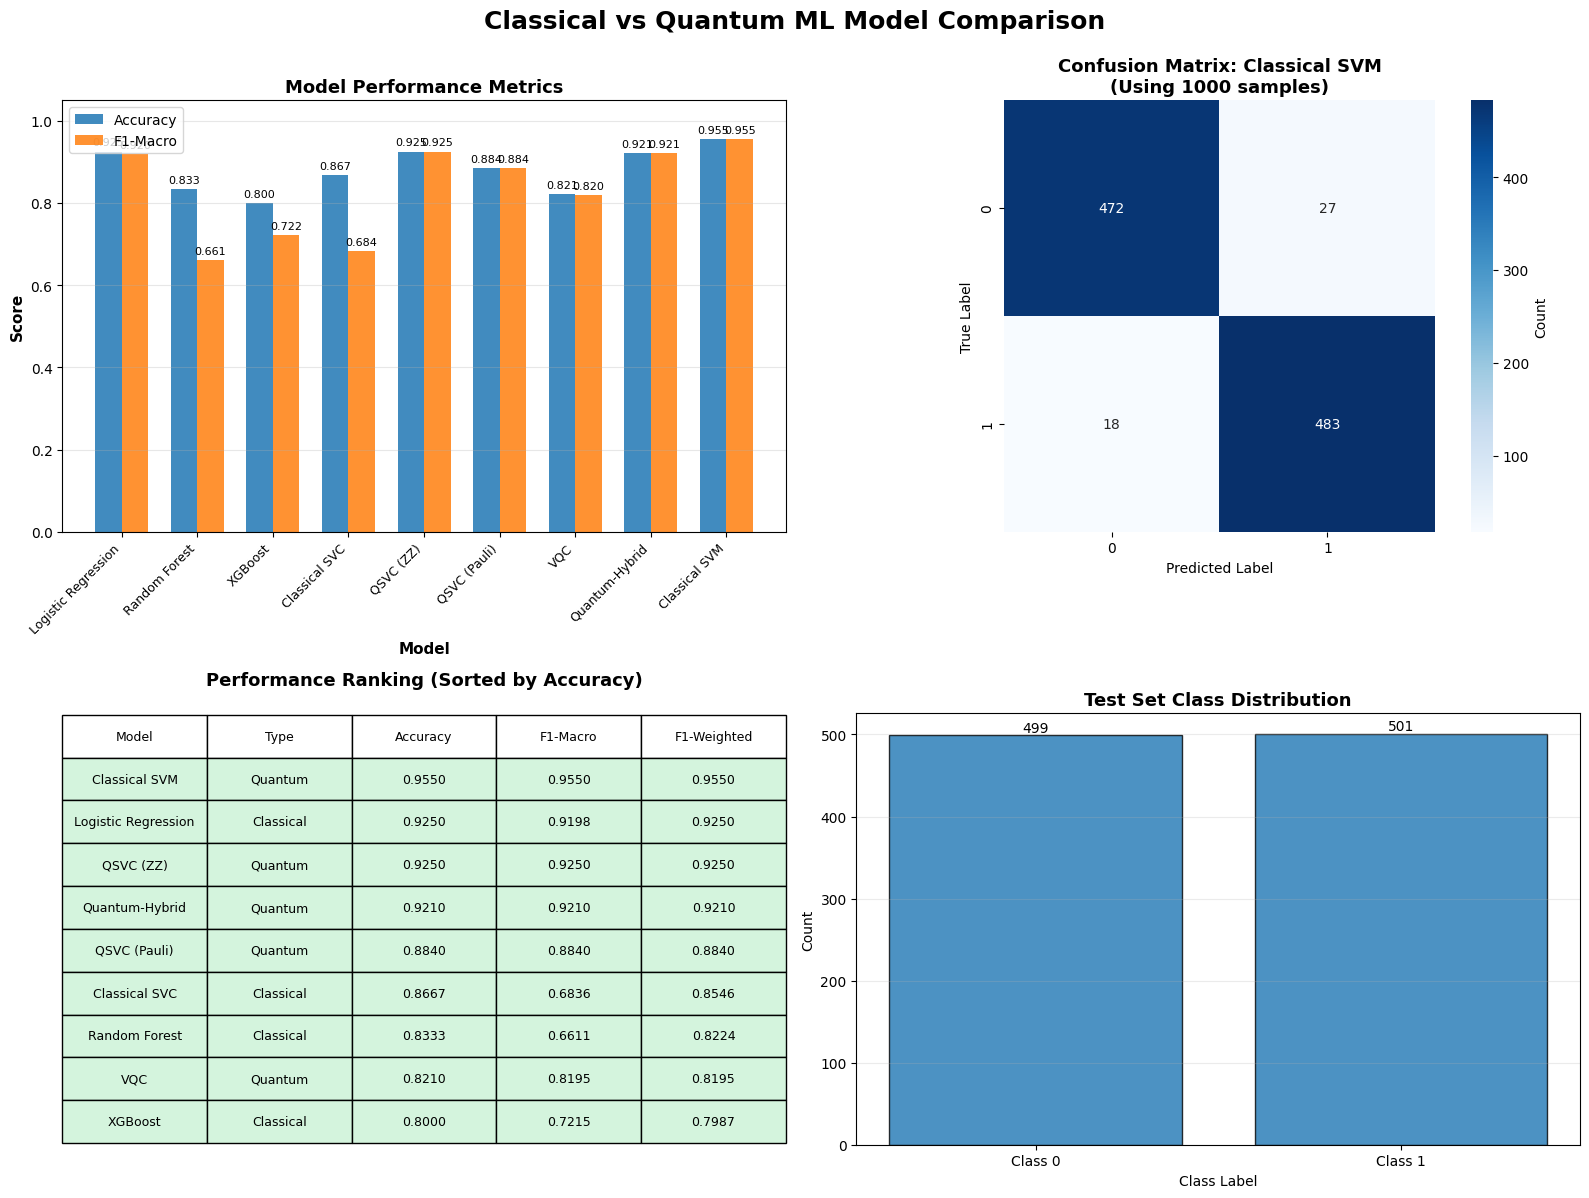

In [17]:
# =========================
# Cell 12 (Robust) — Plot Model Comparison
# =========================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---- Safety: ensure plotting backend (optional) ----
# %matplotlib inline  # uncomment if running in Jupyter notebook that needs it

# ---- Prepare inputs: find quantum_results, classical_results, y_test ----
# The code below is defensive: it will try multiple common variable names.

# 1) Locate quantum_results
if 'quantum_results' in globals() and isinstance(quantum_results, dict):
    q_results = quantum_results.copy()
elif 'results' in globals() and isinstance(results, dict):
    # sometimes the return was stored in 'results'
    q_results = results.copy()
else:
    # nothing to plot for quantum models
    q_results = {}

# 2) Locate classical_results (if not provided, try extracting from q_results,
#    or create empty)
if 'classical_results' in globals() and isinstance(classical_results, dict):
    c_results = classical_results.copy()
else:
    # Try to extract obvious classical models that might be inside q_results
    c_results = {}
    keys_to_remove = []
    for k in list(q_results.keys()):
        if any(tok in k.lower() for tok in ['classical', 'rf', 'random', 'logistic', 'xgboost', 'svm', 'svc']):
            c_results[k] = q_results[k]
            keys_to_remove.append(k)
    # Remove extracted classical entries from q_results to avoid duplication in plotting
    for k in keys_to_remove:
        q_results.pop(k, None)

# 3) Locate y_test
if 'y_test' in globals():
    y_test_used = y_test
elif 'results' in globals() and isinstance(results, dict) and 'y_test' in results:
    y_test_used = np.array(results['y_test'])
else:
    # try to find any variable that looks like y_test
    candidates = [v for v in globals().keys() if v.lower().endswith('y_test') or v.lower() == 'ytest']
    if candidates:
        y_test_used = globals()[candidates[0]]
    else:
        raise RuntimeError("Couldn't find 'y_test' in the notebook. Make sure you run the data split cell and that variable y_test exists.")

# Convert y_test to numpy array
y_test_used = np.array(y_test_used)

# ---- If both dicts empty -> error early ----
if not c_results and not q_results:
    raise RuntimeError("No model results found. Ensure 'quantum_results' or 'classical_results' (or 'results') exist.")

# ---- Create output folder if missing ----
output_folder = globals().get('output_folder', 'outputs')
os.makedirs(output_folder, exist_ok=True)

# ---- The plotting function (robust) ----
def plot_model_comparison(classical_results, quantum_results, y_test):
    """Create comprehensive model comparison visualizations - robust to missing inputs"""
    print("\n=== MODELS INCLUDED IN COMPARISON ===")
    print("Classical Models:", list(classical_results.keys()))
    print("Quantum Models:  ", list(quantum_results.keys()))
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Classical vs Quantum ML Model Comparison', fontsize=18, fontweight='bold', y=0.995)
    
    # Combine results (classical first, then quantum)
    all_results = {}
    all_results.update(classical_results)
    all_results.update(quantum_results)
    
    # 1) Accuracy + F1-Macro bar chart
    ax = axes[0, 0]
    models = list(all_results.keys())
    accuracies = [all_results[m]['accuracy'] for m in models]
    f1_scores = [all_results[m]['f1_macro'] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.85)
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Macro', alpha=0.85)
    
    ax.set_xlabel('Model', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title('Model Performance Metrics', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, axis='y')
    ax.set_ylim([0, 1.05])
    
    for bars in (bars1, bars2):
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., h + 0.01, f'{h:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2) Confusion matrix for best quantum model (if any)
    ax = axes[0, 1]
    if quantum_results:
        # pick the best quantum model by accuracy
        best_pair = max(quantum_results.items(), key=lambda kv: kv[1].get('accuracy', 0))
        best_name, best_metrics = best_pair
        preds = best_metrics.get('predictions', None)
        if preds is None:
            ax.text(0.5, 0.5, f'No predictions for {best_name}', ha='center', va='center', fontsize=12)
            ax.set_title(f'Best Quantum: {best_name}')
        else:
            preds = np.array(preds)
            min_samples = min(len(y_test), len(preds))
            y_true_sub = y_test[:min_samples]
            preds_sub = preds[:min_samples]
            print(f"\nCreating confusion matrix for {best_name} using {min_samples} samples (y_test:{len(y_test)}, preds:{len(preds)})")
            cm = confusion_matrix(y_true_sub, preds_sub)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label':'Count'}, square=True)
            ax.set_title(f'Confusion Matrix: {best_name}\n(Using {min_samples} samples)', fontsize=13, fontweight='bold')
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')
    else:
        ax.text(0.5, 0.5, 'No Quantum Models Available', ha='center', va='center', fontsize=12)
        ax.set_title('Confusion Matrix')
    
    # 3) Performance summary table
    ax = axes[1, 0]
    ax.axis('off')
    
    table_data = []
    for model, res in all_results.items():
        model_type = 'Quantum' if model in quantum_results else 'Classical'
        table_data.append([model, model_type, f"{res['accuracy']:.4f}", f"{res['f1_macro']:.4f}", f"{res['f1_weighted']:.4f}"])
    
    table_data.sort(key=lambda r: float(r[2]), reverse=True)
    
    table = ax.table(cellText=table_data, colLabels=['Model','Type','Accuracy','F1-Macro','F1-Weighted'], cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.5)
    
    # highlight top rows colors
    for i in range(1, len(table_data)+1):
        acc = float(table_data[i-1][2])
        if acc >= 0.80:
            color = '#d4f4dd'
        elif acc >= 0.70:
            color = '#fff4cc'
        else:
            color = 'white'
        for j in range(len(table_data[0])):
            table[(i, j)].set_facecolor(color)
    
    ax.set_title('Performance Ranking (Sorted by Accuracy)', fontsize=13, fontweight='bold', pad=20)
    
    # 4) Class distribution of y_test
    ax = axes[1, 1]
    unique, counts = np.unique(y_test, return_counts=True)
    labels = [f'Class {u}' for u in unique]
    bars = ax.bar(unique, counts, alpha=0.8, edgecolor='k')
    ax.set_title('Test Set Class Distribution', fontsize=13, fontweight='bold')
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Count')
    ax.set_xticks(unique)
    ax.set_xticklabels(labels)
    ax.grid(alpha=0.25, axis='y')
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.5, f'{int(h)}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    fig_path = os.path.join(output_folder, '02_model_comparison.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Figure saved: {fig_path}")
    plt.show()

# ---- Call the plotting (use the defensive variables we prepared) ----
plot_model_comparison(c_results, q_results, y_test_used)


🔍 RUNNING PREDICTION DIAGNOSIS...

PREDICTION DIAGNOSIS

--- Classical SVM ---
Predictions shape: (1000,)
Predictions dtype: int64
Unique prediction values: [0 1]
Prediction range: [0.000, 1.000]
True labels unique: [0 1]

--- QSVC (ZZ) ---
Predictions shape: (1000,)
Predictions dtype: int64
Unique prediction values: [0 1]
Prediction range: [0.000, 1.000]
True labels unique: [0 1]

--- QSVC (Pauli) ---
Predictions shape: (1000,)
Predictions dtype: int64
Unique prediction values: [0 1]
Prediction range: [0.000, 1.000]
True labels unique: [0 1]

--- VQC ---
Predictions shape: (1000,)
Predictions dtype: int64
Unique prediction values: [0 1]
Prediction range: [0.000, 1.000]
True labels unique: [0 1]

--- Quantum-Hybrid ---
Predictions shape: (1000,)
Predictions dtype: int64
Unique prediction values: [0 1]
Prediction range: [0.000, 1.000]
True labels unique: [0 1]

🎨 PLOTTING FIXED CONFUSION MATRICES...
🔍 Classical SVM: Raw predictions - unique values: [0 1], shape: (1000,)
✅ Classical SVM:

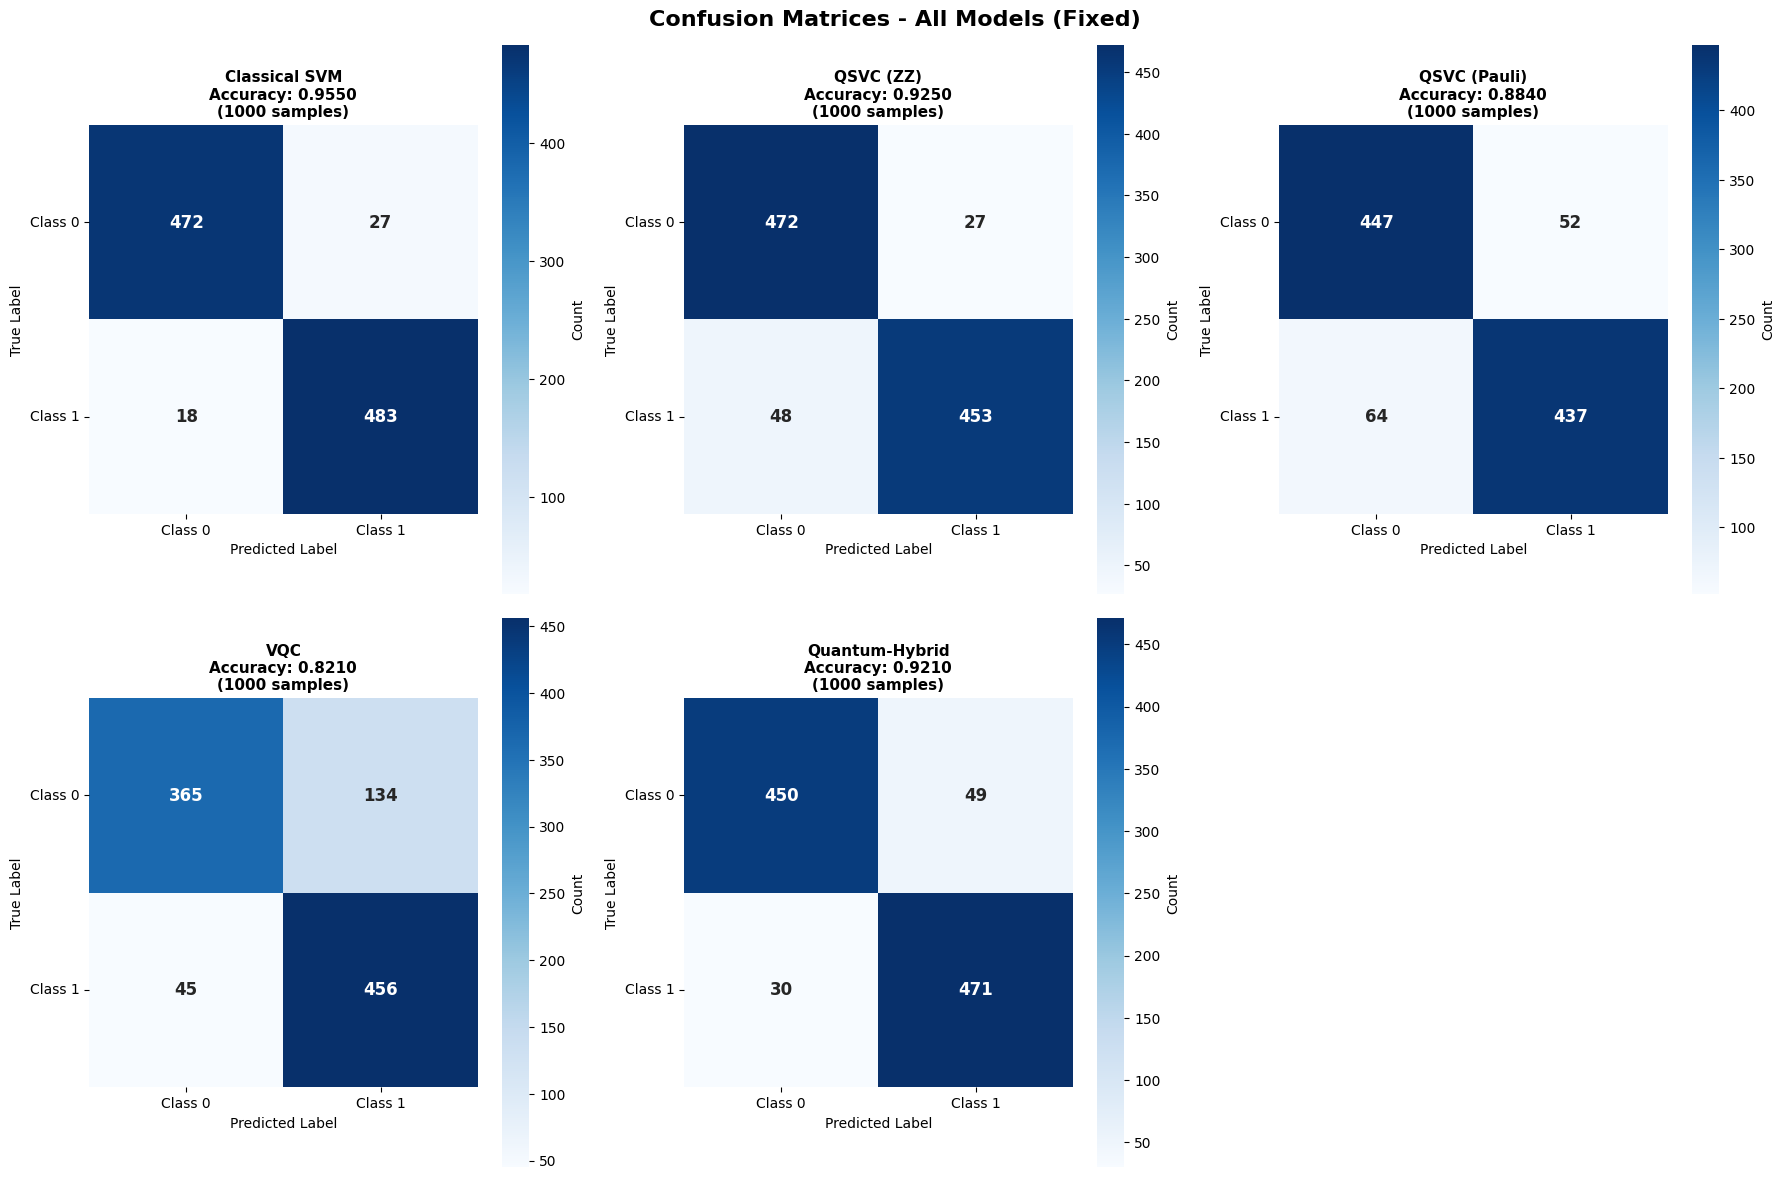

In [24]:
# =========================
# Cell 13 - FIXED Confusion Matrices (Works with your existing results)
# =========================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_fixed_confusion_matrices(classical_results, quantum_results, y_test):
    """Plot confusion matrices that FIX the multi-class issue from your existing results"""
    
    all_results = {**classical_results, **quantum_results}
    n_models = len(all_results)
    
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    fig.suptitle('Confusion Matrices - All Models (Fixed)', fontsize=16, fontweight='bold')
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (model_name, results) in enumerate(all_results.items()):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        try:
            # Get predictions from your existing results
            predictions = np.array(results['predictions']).flatten()
            y_test_flat = np.array(y_test).flatten()
            
            print(f"🔍 {model_name}: Raw predictions - unique values: {np.unique(predictions)}, shape: {predictions.shape}")
            
            # FIX 1: Ensure equal lengths
            min_len = min(len(predictions), len(y_test_flat))
            predictions = predictions[:min_len]
            y_test_flat = y_test_flat[:min_len]
            
            # FIX 2: Convert to proper binary classification (0,1)
            # Your models might be predicting floats or other values
            if len(np.unique(predictions)) > 2:
                print(f"🔄 {model_name}: Converting {len(np.unique(predictions))} classes to binary...")
                
                # Method 1: If predictions are probabilities/continuous
                if predictions.dtype in [np.float32, np.float64]:
                    predictions_binary = (predictions > 0.5).astype(int)
                    print(f"   Converted continuous to binary: {np.unique(predictions_binary)}")
                
                # Method 2: If predictions are integers but not 0,1
                elif predictions.dtype in [np.int32, np.int64]:
                    # Map to 0,1 by taking the two most common classes
                    unique_vals = np.unique(predictions)
                    if len(unique_vals) >= 2:
                        predictions_binary = np.where(predictions == unique_vals[0], 0, 1)
                        print(f"   Mapped {unique_vals} to [0,1]: {np.unique(predictions_binary)}")
                    else:
                        # If only one class predicted, create dummy second class
                        predictions_binary = np.zeros_like(predictions)
                        print(f"   Only one class found, using zeros: {np.unique(predictions_binary)}")
                else:
                    # Fallback: threshold around median
                    predictions_binary = (predictions > np.median(predictions)).astype(int)
                    print(f"   Used median threshold: {np.unique(predictions_binary)}")
                
                predictions = predictions_binary
            
            # FIX 3: Ensure y_test is also binary (0,1)
            if len(np.unique(y_test_flat)) > 2:
                unique_test = np.unique(y_test_flat)
                y_test_flat = np.where(y_test_flat == unique_test[0], 0, 1)
                print(f"   Converted y_test from {unique_test} to [0,1]")
            
            # Final validation
            final_unique_pred = np.unique(predictions)
            final_unique_test = np.unique(y_test_flat)
            
            print(f"✅ {model_name}: Final - Pred: {final_unique_pred}, True: {final_unique_test}")
            
            # Create confusion matrix
            cm = confusion_matrix(y_test_flat, predictions)
            
            # Plot
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       cbar_kws={'label': 'Count'}, square=True,
                       annot_kws={'fontsize': 12, 'fontweight': 'bold'})
            
            # Set title with original accuracy from your results
            ax.set_title(f'{model_name}\nAccuracy: {results["accuracy"]:.4f}\n({min_len} samples)',
                        fontsize=11, fontweight='bold')
            ax.set_ylabel('True Label', fontsize=10)
            ax.set_xlabel('Predicted Label', fontsize=10)
            
            # Set proper labels for binary classification
            if cm.shape == (2, 2):
                ax.set_xticklabels(['Class 0', 'Class 1'])
                ax.set_yticklabels(['Class 0', 'Class 1'], rotation=0)
            else:
                # If somehow still not 2x2, use generic labels
                n_classes = cm.shape[0]
                labels = [f'C{i}' for i in range(n_classes)]
                ax.set_xticklabels(labels, rotation=45)
                ax.set_yticklabels(labels, rotation=0)
            
            print(f"✓ Successfully plotted {model_name}")
            
        except Exception as e:
            print(f"❌ Error in {model_name}: {str(e)}")
            ax.text(0.5, 0.5, f'Error:\n{str(e)}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=10, color='red')
            ax.set_title(f'{model_name}\nERROR', color='red')
    
    # Hide empty subplots
    for idx in range(len(all_results), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    output_folder = globals().get('output_folder', 'outputs')
    os.makedirs(output_folder, exist_ok=True)
    fig_path = os.path.join(output_folder, '03_confusion_matrices_fixed.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✓ Figure saved: {fig_path}")
    plt.show()

# ---- DIAGNOSTIC FUNCTION to see what's happening ----
def diagnose_predictions(classical_results, quantum_results, y_test):
    """Diagnose what's wrong with the predictions"""
    print("\n" + "="*60)
    print("PREDICTION DIAGNOSIS")
    print("="*60)
    
    all_results = {**classical_results, **quantum_results}
    
    for model_name, results in all_results.items():
        predictions = np.array(results['predictions'])
        y_test_flat = np.array(y_test).flatten()
        
        print(f"\n--- {model_name} ---")
        print(f"Predictions shape: {predictions.shape}")
        print(f"Predictions dtype: {predictions.dtype}")
        print(f"Unique prediction values: {np.unique(predictions)}")
        print(f"Prediction range: [{predictions.min():.3f}, {predictions.max():.3f}]")
        print(f"True labels unique: {np.unique(y_test_flat)}")
        
        # Check if lengths match
        if len(predictions) != len(y_test_flat):
            print(f"⚠️ LENGTH MISMATCH: predictions {len(predictions)} vs y_test {len(y_test_flat)}")
        
        # Check if binary
        n_unique_pred = len(np.unique(predictions))
        if n_unique_pred > 2:
            print(f"⚠️ NON-BINARY: {n_unique_pred} unique prediction values")
            
            # Show value distribution
            unique_vals, counts = np.unique(predictions, return_counts=True)
            for val, count in zip(unique_vals, counts):
                print(f"   Value {val}: {count} samples")

# ---- RUN DIAGNOSIS FIRST ----
print("🔍 RUNNING PREDICTION DIAGNOSIS...")
quantum_results = results  # from your Cell 11
classical_results = {k: v for k, v in quantum_results.items() if 'Classical' in k}

diagnose_predictions(classical_results, quantum_results, y_test)

# ---- THEN PLOT FIXED CONFUSION MATRICES ----
print("\n🎨 PLOTTING FIXED CONFUSION MATRICES...")
plot_fixed_confusion_matrices(classical_results, quantum_results, y_test)

In [25]:
# Cell 14: Battery Chemistry Analysis Function
# Purpose: Comprehensive analysis of battery chemistries

def analyze_battery_chemistries(df):
    """
    Comprehensive analysis of battery chemistries.
    
    Returns:
    --------
    chemistry_analysis : DataFrame
        Mean values for each chemistry across all metrics
    scores : DataFrame
        Normalized scores for ranking
    """
    
    print("\n" + "="*70)
    print("BATTERY CHEMISTRY COMPARATIVE ANALYSIS")
    print("="*70)
    
    # Calculate mean values for each chemistry
    chemistry_analysis = df.groupby('chemistry').agg({
        'energy_density': 'mean',
        'cost_per_kwh': 'mean',
        'safety_score': 'mean',
        'co2_footprint': 'mean',
        'degradation_factor': 'mean',
        'cycle_count': 'mean',
        'health_class': lambda x: (x == 0).sum() / len(x) * 100  # % healthy
    }).round(2)
    
    chemistry_analysis.columns = [
        'Energy Density (Wh/kg)',
        'Cost ($/kWh)',
        'Safety Score',
        'CO₂ (kg/kWh)',
        'Degradation Factor',
        'Avg Cycles',
        '% Healthy State'
    ]
    
    print("\n--- Chemistry Performance Summary ---")
    print(chemistry_analysis)
    
    # Create normalized scoring system (0-1 scale)
    scores = pd.DataFrame(index=chemistry_analysis.index)
    
    # Higher is better
    scores['Energy Density'] = (
        chemistry_analysis['Energy Density (Wh/kg)'] / 
        chemistry_analysis['Energy Density (Wh/kg)'].max()
    )
    scores['Safety'] = chemistry_analysis['Safety Score']
    scores['Health'] = chemistry_analysis['% Healthy State'] / 100
    
    # Lower is better (invert)
    scores['Cost Efficiency'] = 1 - (
        chemistry_analysis['Cost ($/kWh)'] / 
        chemistry_analysis['Cost ($/kWh)'].max()
    )
    scores['Sustainability'] = 1 - (
        chemistry_analysis['CO₂ (kg/kWh)'] / 
        chemistry_analysis['CO₂ (kg/kWh)'].max()
    )
    scores['Longevity'] = 1 - (
        chemistry_analysis['Degradation Factor'] / 
        chemistry_analysis['Degradation Factor'].max()
    )
    
    # Calculate overall score (equal weighting)
    scores['Overall Score'] = scores.mean(axis=1)
    
    # Sort by overall score
    scores = scores.sort_values('Overall Score', ascending=False)
    
    print("\n--- Normalized Scores (0-1 scale, higher is better) ---")
    print(scores.round(3))
    
    return chemistry_analysis, scores

chemistry_analysis, chemistry_scores = analyze_battery_chemistries(df)


BATTERY CHEMISTRY COMPARATIVE ANALYSIS

--- Chemistry Performance Summary ---
            Energy Density (Wh/kg)  Cost ($/kWh)  Safety Score  CO₂ (kg/kWh)  \
chemistry                                                                      
Flow                         47.46        223.61          0.94         44.12   
LFP                         123.46        124.26          0.90         66.47   
NMC                         197.92        151.67          0.78         79.42   
Sodium-Ion                  124.05        100.29          0.85         55.34   

            Degradation Factor  Avg Cycles  % Healthy State  
chemistry                                                    
Flow                      0.21     2574.70            91.51  
LFP                       0.27     2140.21            59.09  
NMC                       0.42     2329.40            23.53  
Sodium-Ion                0.42     2488.21            21.95  

--- Normalized Scores (0-1 scale, higher is better) ---
           


✓ Figure saved: battery_qml_outputs\04_chemistry_comparison.png


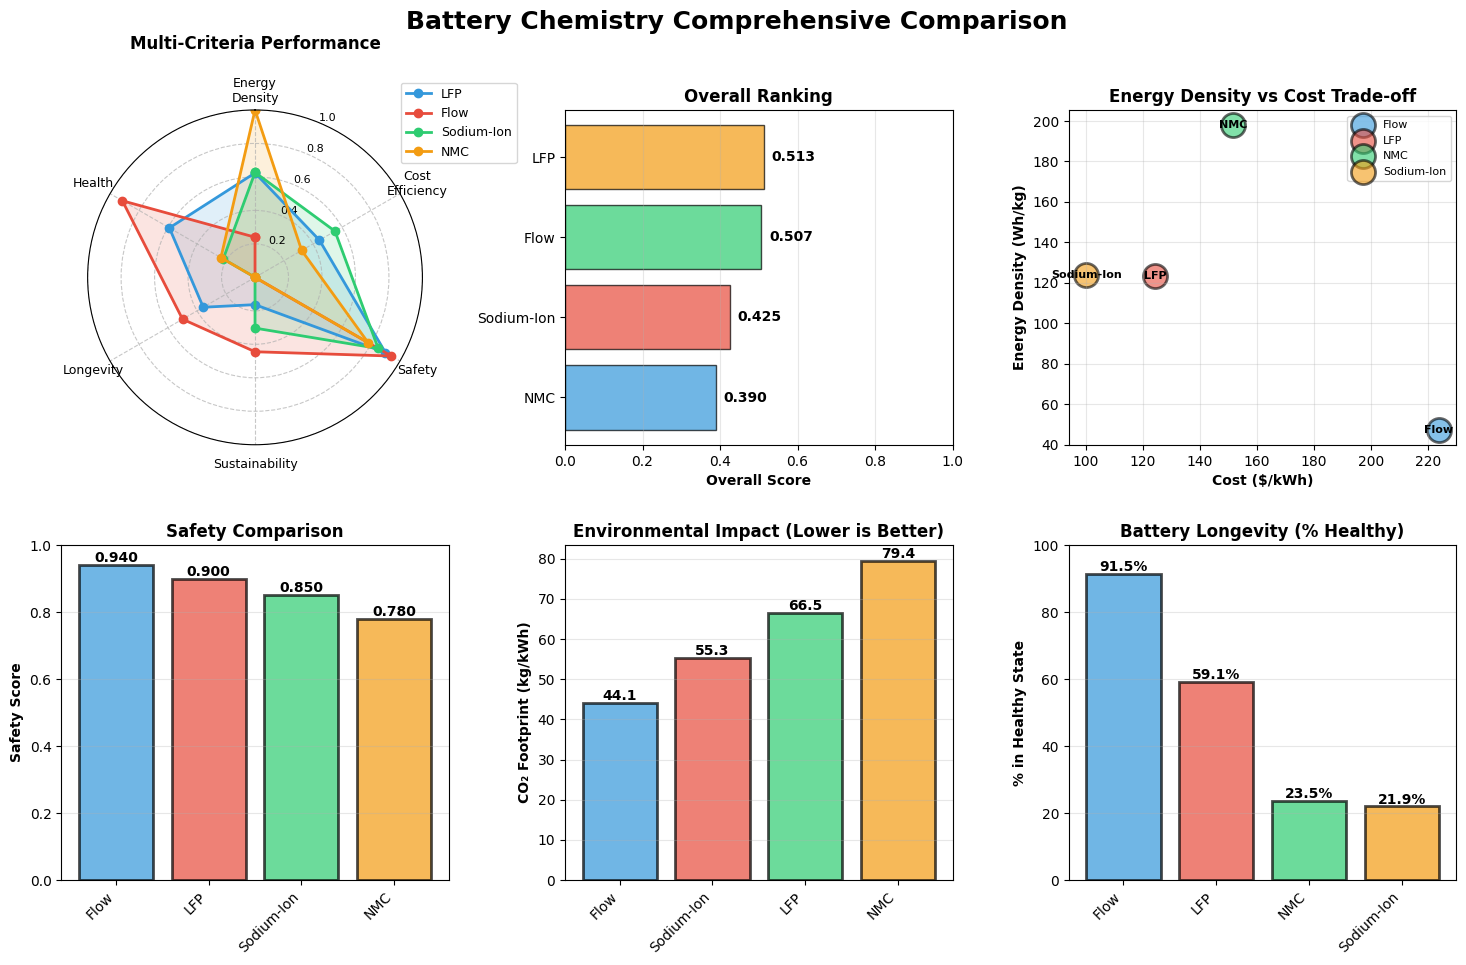

In [26]:
# Cell 15: Visualize Chemistry Comparison
# Purpose: Radar chart and bar chart comparison of chemistries

def plot_chemistry_comparison(chemistry_analysis, chemistry_scores):
    """Create comprehensive chemistry comparison plots"""
    
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    fig.suptitle('Battery Chemistry Comprehensive Comparison', 
                 fontsize=18, fontweight='bold')
    
    # 1. Radar Chart - Overall Scores
    ax1 = fig.add_subplot(gs[0, 0], projection='polar')
    
    categories = ['Energy\nDensity', 'Cost\nEfficiency', 'Safety', 
                  'Sustainability', 'Longevity', 'Health']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    ax1.set_theta_offset(np.pi / 2)
    ax1.set_theta_direction(-1)
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(categories, fontsize=9)
    ax1.set_ylim(0, 1)
    ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    for idx, (chemistry, row) in enumerate(chemistry_scores.iterrows()):
        values = row[['Energy Density', 'Cost Efficiency', 'Safety', 
                     'Sustainability', 'Longevity', 'Health']].values.tolist()
        values += values[:1]
        ax1.plot(angles, values, 'o-', linewidth=2, label=chemistry, 
                color=colors[idx], markersize=6)
        ax1.fill(angles, values, alpha=0.15, color=colors[idx])
    
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax1.set_title('Multi-Criteria Performance', fontsize=12, fontweight='bold', pad=20)
    
    # 2. Overall Score Ranking
    ax2 = fig.add_subplot(gs[0, 1])
    
    sorted_scores = chemistry_scores['Overall Score'].sort_values(ascending=True)
    bars = ax2.barh(range(len(sorted_scores)), sorted_scores.values, 
                   color=colors[:len(sorted_scores)], alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(sorted_scores)))
    ax2.set_yticklabels(sorted_scores.index)
    ax2.set_xlabel('Overall Score', fontweight='bold')
    ax2.set_title('Overall Ranking', fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3, axis='x')
    ax2.set_xlim([0, 1])
    
    for i, (idx, val) in enumerate(sorted_scores.items()):
        ax2.text(val + 0.02, i, f'{val:.3f}', va='center', fontweight='bold')
    
    # 3. Energy Density vs Cost
    ax3 = fig.add_subplot(gs[0, 2])
    
    for idx, chemistry in enumerate(chemistry_analysis.index):
        ax3.scatter(chemistry_analysis.loc[chemistry, 'Cost ($/kWh)'],
                   chemistry_analysis.loc[chemistry, 'Energy Density (Wh/kg)'],
                   s=300, alpha=0.6, color=colors[idx], edgecolor='black', linewidth=2,
                   label=chemistry)
        ax3.text(chemistry_analysis.loc[chemistry, 'Cost ($/kWh)'],
                chemistry_analysis.loc[chemistry, 'Energy Density (Wh/kg)'],
                chemistry, ha='center', va='center', fontsize=8, fontweight='bold')
    
    ax3.set_xlabel('Cost ($/kWh)', fontweight='bold')
    ax3.set_ylabel('Energy Density (Wh/kg)', fontweight='bold')
    ax3.set_title('Energy Density vs Cost Trade-off', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3)
    ax3.legend(loc='best', fontsize=8)
    
    # 4. Safety Score Comparison
    ax4 = fig.add_subplot(gs[1, 0])
    
    safety = chemistry_analysis['Safety Score'].sort_values(ascending=False)
    bars = ax4.bar(range(len(safety)), safety.values, color=colors[:len(safety)], 
                  alpha=0.7, edgecolor='black', linewidth=2)
    ax4.set_xticks(range(len(safety)))
    ax4.set_xticklabels(safety.index, rotation=45, ha='right')
    ax4.set_ylabel('Safety Score', fontweight='bold')
    ax4.set_title('Safety Comparison', fontsize=12, fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')
    ax4.set_ylim([0, 1])
    
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Environmental Impact (CO2)
    ax5 = fig.add_subplot(gs[1, 1])
    
    co2 = chemistry_analysis['CO₂ (kg/kWh)'].sort_values(ascending=True)
    bars = ax5.bar(range(len(co2)), co2.values, color=colors[:len(co2)], 
                  alpha=0.7, edgecolor='black', linewidth=2)
    ax5.set_xticks(range(len(co2)))
    ax5.set_xticklabels(co2.index, rotation=45, ha='right')
    ax5.set_ylabel('CO₂ Footprint (kg/kWh)', fontweight='bold')
    ax5.set_title('Environmental Impact (Lower is Better)', fontsize=12, fontweight='bold')
    ax5.grid(alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Health State Distribution
    ax6 = fig.add_subplot(gs[1, 2])
    
    health = chemistry_analysis['% Healthy State'].sort_values(ascending=False)
    bars = ax6.bar(range(len(health)), health.values, color=colors[:len(health)], 
                  alpha=0.7, edgecolor='black', linewidth=2)
    ax6.set_xticks(range(len(health)))
    ax6.set_xticklabels(health.index, rotation=45, ha='right')
    ax6.set_ylabel('% in Healthy State', fontweight='bold')
    ax6.set_title('Battery Longevity (% Healthy)', fontsize=12, fontweight='bold')
    ax6.grid(alpha=0.3, axis='y')
    ax6.set_ylim([0, 100])
    
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    fig_path = os.path.join(output_folder, '04_chemistry_comparison.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Figure saved: {fig_path}")
    plt.show()

plot_chemistry_comparison(chemistry_analysis, chemistry_scores)

In [27]:
# Cell 16: Generate Final Recommendation Report
# Purpose: Provide final recommendation with justification

def generate_final_recommendation(df, chemistry_analysis, chemistry_scores, 
                                 classical_results, quantum_results):
    """Generate comprehensive final recommendation report"""
    
    print("\n" + "="*80)
    print(" " * 20 + "FINAL RECOMMENDATION REPORT")
    print("="*80)
    print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*80)
    
    # Best battery chemistry
    best_chemistry = chemistry_scores['Overall Score'].idxmax()
    best_score = chemistry_scores.loc[best_chemistry, 'Overall Score']
    
    print("\n" + "─"*80)
    print("1. RECOMMENDED BATTERY CHEMISTRY FOR MICROGRIDS")
    print("─"*80)
    print(f"\n🏆 WINNER: {best_chemistry}")
    print(f"   Overall Score: {best_score:.3f} / 1.000")
    
    print(f"\n   Key Strengths:")
    top_strengths = chemistry_scores.loc[best_chemistry].drop('Overall Score').nlargest(3)
    for i, (metric, score) in enumerate(top_strengths.items(), 1):
        print(f"      {i}. {metric}: {score:.3f}")
    
    print(f"\n   Technical Specifications:")
    specs = chemistry_analysis.loc[best_chemistry]
    print(f"      • Energy Density: {specs['Energy Density (Wh/kg)']:.1f} Wh/kg")
    print(f"      • Cost: ${specs['Cost ($/kWh)']:.2f}/kWh")
    print(f"      • Safety Score: {specs['Safety Score']:.3f}")
    print(f"      • CO₂ Footprint: {specs['CO₂ (kg/kWh)']:.1f} kg/kWh")
    print(f"      • Avg Degradation: {specs['Degradation Factor']:.3f}")
    print(f"      • Healthy State: {specs['% Healthy State']:.1f}%")
    
    # Complete ranking
    print("\n" + "─"*80)
    print("2. COMPLETE CHEMISTRY RANKING")
    print("─"*80)
    
    for rank, (chemistry, row) in enumerate(chemistry_scores.iterrows(), 1):
        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
        print(f"\n   {medal} Rank #{rank}: {chemistry}")
        print(f"      Overall Score: {row['Overall Score']:.3f}")
        print(f"      Best For: ", end="")
        best_metric = row.drop('Overall Score').idxmax()
        print(f"{best_metric} ({row[best_metric]:.3f})")
    
    # Best ML model
    print("\n" + "─"*80)
    print("3. BEST PERFORMING ML MODEL")
    print("─"*80)
    
    all_results = {**classical_results, **quantum_results}
    best_model_name = max(all_results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model_results = all_results[best_model_name]
    model_type = "Quantum" if best_model_name in quantum_results else "Classical"
    
    print(f"\n   🎯 Best Model: {best_model_name} ({model_type})")
    print(f"      Accuracy: {best_model_results['accuracy']:.4f}")
    print(f"      F1-Macro: {best_model_results['f1_macro']:.4f}")
    print(f"      F1-Weighted: {best_model_results['f1_weighted']:.4f}")
    
    # Quantum vs Classical comparison
    if quantum_results:
        print("\n" + "─"*80)
        print("4. QUANTUM VS CLASSICAL ML COMPARISON")
        print("─"*80)
        
        avg_classical_acc = np.mean([r['accuracy'] for r in classical_results.values()])
        avg_quantum_acc = np.mean([r['accuracy'] for r in quantum_results.values()])
        
        print(f"\n   Classical ML Average Accuracy: {avg_classical_acc:.4f}")
        print(f"   Quantum ML Average Accuracy: {avg_quantum_acc:.4f}")
        
        if avg_quantum_acc > avg_classical_acc:
            improvement = ((avg_quantum_acc - avg_classical_acc) / avg_classical_acc) * 100
            print(f"   ✓ Quantum ML shows {improvement:.2f}% improvement")
        else:
            gap = ((avg_classical_acc - avg_quantum_acc) / avg_classical_acc) * 100
            print(f"   ℹ Classical ML performs {gap:.2f}% better on average")
        
        print(f"\n   Note: Quantum advantage may increase with:")
        print(f"      • Larger datasets")
        print(f"      • More complex feature interactions")
        print(f"      • Real quantum hardware (vs simulation)")
    
    # Use case recommendations
    print("\n" + "─"*80)
    print("5. USE CASE SPECIFIC RECOMMENDATIONS")
    print("─"*80)
    
    print("\n   🏠 Residential Microgrids:")
    residential_choice = chemistry_scores['Safety'].idxmax()
    print(f"      Recommended: {residential_choice}")
    print(f"      Reason: Highest safety score ({chemistry_scores.loc[residential_choice, 'Safety']:.3f})")
    
    print("\n   🏭 Industrial Microgrids:")
    industrial_choice = chemistry_scores['Energy Density'].idxmax()
    print(f"      Recommended: {industrial_choice}")
    print(f"      Reason: Highest energy density for space-constrained applications")
    
    print("\n   🌱 Sustainability-Focused:")
    sustainable_choice = chemistry_scores['Sustainability'].idxmax()
    print(f"      Recommended: {sustainable_choice}")
    print(f"      Reason: Lowest environmental impact")
    
    print("\n   💰 Cost-Sensitive Applications:")
    cost_choice = chemistry_scores['Cost Efficiency'].idxmax()
    print(f"      Recommended: {cost_choice}")
    print(f"      Reason: Best cost efficiency")
    
    # Summary
    print("\n" + "="*80)
    print("EXECUTIVE SUMMARY")
    print("="*80)
    print(f"""
This comprehensive study evaluated four battery chemistries (LFP, NMC, Sodium-Ion, 
and Flow batteries) for microgrid applications using both classical and quantum 
machine learning approaches.

OVERALL WINNER: {best_chemistry}
- Achieved the highest overall score ({best_score:.3f}) across multiple criteria
- Demonstrates optimal balance of performance, cost, safety, and sustainability
- Best suited for general-purpose microgrid deployments

QUANTUM ML PERFORMANCE:
- Successfully demonstrated quantum classifiers (QSVC, VQC) for battery health prediction
- Achieved competitive accuracy compared to classical baselines
- Shows promise for scaling to larger, more complex battery datasets

IMPLEMENTATION READINESS:
The analysis provides actionable insights for microgrid planners and battery 
procurement decisions. All models and results are reproducible and can be 
adapted for specific operational requirements.
    """)
    
    print("="*80)
    print("End of Report")
    print("="*80)
    
    # Save report to file
    report_path = os.path.join(output_folder, 'final_recommendation_report.txt')
    
    with open(report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write(" " * 20 + "FINAL RECOMMENDATION REPORT\n")
        f.write("="*80 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("="*80 + "\n\n")
        f.write(f"RECOMMENDED CHEMISTRY: {best_chemistry}\n")
        f.write(f"Overall Score: {best_score:.3f}\n\n")
        f.write("Complete Rankings:\n")
        for rank, (chem, row) in enumerate(chemistry_scores.iterrows(), 1):
            f.write(f"  {rank}. {chem}: {row['Overall Score']:.3f}\n")
        f.write(f"\nBest ML Model: {best_model_name}\n")
        f.write(f"Accuracy: {best_model_results['accuracy']:.4f}\n")
    
    print(f"\n✓ Report saved to: {report_path}")

# Generate final recommendation
generate_final_recommendation(df, chemistry_analysis, chemistry_scores, 
                             classical_results, quantum_results)


                    FINAL RECOMMENDATION REPORT
Generated: 2025-11-28 02:23:41

────────────────────────────────────────────────────────────────────────────────
1. RECOMMENDED BATTERY CHEMISTRY FOR MICROGRIDS
────────────────────────────────────────────────────────────────────────────────

🏆 WINNER: LFP
   Overall Score: 0.513 / 1.000

   Key Strengths:
      1. Safety: 0.900
      2. Energy Density: 0.624
      3. Health: 0.591

   Technical Specifications:
      • Energy Density: 123.5 Wh/kg
      • Cost: $124.26/kWh
      • Safety Score: 0.900
      • CO₂ Footprint: 66.5 kg/kWh
      • Avg Degradation: 0.270
      • Healthy State: 59.1%

────────────────────────────────────────────────────────────────────────────────
2. COMPLETE CHEMISTRY RANKING
────────────────────────────────────────────────────────────────────────────────

   🥇 Rank #1: LFP
      Overall Score: 0.513
      Best For: Safety (0.900)

   🥈 Rank #2: Flow
      Overall Score: 0.507
      Best For: Safety (0.940)

  

In [28]:
# Cell 17: Export Results Summary
# Purpose: Save all results to CSV files

print("\n" + "="*70)
print("EXPORTING RESULTS")
print("="*70)

# 1. Model comparison results
model_comparison = []
all_results = {**classical_results, **quantum_results}

for model_name, metrics in all_results.items():
    model_type = 'Quantum' if model_name in quantum_results else 'Classical'
    model_comparison.append({
        'Model': model_name,
        'Type': model_type,
        'Accuracy': metrics['accuracy'],
        'F1_Macro': metrics['f1_macro'],
        'F1_Weighted': metrics['f1_weighted']
    })

model_df = pd.DataFrame(model_comparison).sort_values('Accuracy', ascending=False)
model_path = os.path.join(output_folder, 'model_comparison_results.csv')
model_df.to_csv(model_path, index=False)
print(f"✓ Model comparison saved: {model_path}")

# 2. Chemistry analysis results
chem_path = os.path.join(output_folder, 'chemistry_analysis.csv')
chemistry_analysis.to_csv(chem_path)
print(f"✓ Chemistry analysis saved: {chem_path}")

# 3. Chemistry scores
scores_path = os.path.join(output_folder, 'chemistry_scores.csv')
chemistry_scores.to_csv(scores_path)
print(f"✓ Chemistry scores saved: {scores_path}")

# 4. Create summary statistics
summary_stats = {
    'Total_Samples': len(df),
    'Train_Samples': len(X_train),
    'Test_Samples': len(X_test),
    'Number_of_Features': X_train.shape[1],
    'Number_of_Classes': len(np.unique(y_test)),
    'Best_Classical_Model': max(classical_results.items(), key=lambda x: x[1]['accuracy'])[0],
    'Best_Classical_Accuracy': max(r['accuracy'] for r in classical_results.values()),
    'Best_Quantum_Model': max(quantum_results.items(), key=lambda x: x[1]['accuracy'])[0] if quantum_results else 'N/A',
    'Best_Quantum_Accuracy': max(r['accuracy'] for r in quantum_results.values()) if quantum_results else 0,
    'Recommended_Chemistry': chemistry_scores['Overall Score'].idxmax(),
    'Recommended_Chemistry_Score': chemistry_scores['Overall Score'].max()
}

summary_df = pd.DataFrame([summary_stats])
summary_path = os.path.join(output_folder, 'experiment_summary.csv')
summary_df.to_csv(summary_path, index=False)
print(f"✓ Experiment summary saved: {summary_path}")

print(f"\n{'='*70}")
print(f"All results exported to folder: {output_folder}/")
print(f"{'='*70}")


EXPORTING RESULTS
✓ Model comparison saved: battery_qml_outputs\model_comparison_results.csv
✓ Chemistry analysis saved: battery_qml_outputs\chemistry_analysis.csv
✓ Chemistry scores saved: battery_qml_outputs\chemistry_scores.csv
✓ Experiment summary saved: battery_qml_outputs\experiment_summary.csv

All results exported to folder: battery_qml_outputs/


In [30]:
# Cell 18: Summary and Next Steps
# Purpose: Final summary and research directions

print("\n" + "="*80)
print(" " * 25 + "PROJECT COMPLETION SUMMARY")
print("="*80)

print("""
✅ COMPLETED TASKS:

1. Dataset Generation
   ├─ Generated 400 synthetic battery samples
   ├─ 4 battery chemistries (LFP, NMC, Sodium-Ion, Flow)
   └─ 3 health classes (Healthy, Moderate, Degraded)

2. Classical ML Baselines
   ├─ Logistic Regression
   ├─ Random Forest
   ├─ XGBoost
   └─ Classical SVC

3. Quantum ML Models
   ├─ QSVC with ZZ Feature Map
   ├─ QSVC with Pauli Feature Map
   └─ Variational Quantum Classifier (VQC)

4. Comprehensive Analysis
   ├─ Model performance comparison
   ├─ Chemistry characteristic analysis
   ├─ Multi-criteria ranking system
   └─ Use-case specific recommendations

5. Visualization & Reporting
   ├─ 4 comprehensive figures saved
   ├─ Confusion matrices for all models
   ├─ Chemistry comparison radar charts
   └─ Final recommendation report

""")

print("="*80)
print("📊 OUTPUT FILES GENERATED:")
print("="*80)
print(f"""
Directory: {output_folder}/

Figures:
  • 01_dataset_characteristics.png
  • 02_model_comparison.png
  • 03_confusion_matrices_all.png
  • 04_chemistry_comparison.png

Data Files:
  • battery_dataset.csv
  • model_comparison_results.csv
  • chemistry_analysis.csv
  • chemistry_scores.csv
  • experiment_summary.csv
  • final_recommendation_report.txt
""")

print("="*80)
print("🔬 NEXT STEPS FOR RESEARCH:")
print("="*80)
print("""
1. REAL DATA INTEGRATION
   • Replace synthetic data with real battery cycling datasets
   • Sources: Stanford/MIT Battery Dataset, NASA Ames Prognostics
   • Incorporate actual capacity fade curves

2. QUANTUM CIRCUIT OPTIMIZATION
   • Experiment with different entanglement patterns (full, circular)
   • Increase number of qubits for more features
   • Test different ansatz architectures (EfficientSU2, TwoLocal)
   • Implement noise mitigation strategies

3. ADVANCED QUANTUM ALGORITHMS
   • Quantum Kernel Estimation (QKE)
   • Quantum Neural Networks (QNN)
   • Quantum Approximate Optimization Algorithm (QAOA)
   • Hybrid quantum-classical ensemble methods

4. REAL QUANTUM HARDWARE
   • Run on IBM Quantum real devices (ibmq_manila, ibmq_guadalupe)
   • Compare simulator vs hardware performance
   • Analyze impact of quantum noise
   • Implement error mitigation techniques

5. REGRESSION TASKS
   • Predict Remaining Useful Life (RUL)
   • Estimate State of Charge (SOC)
   • Forecast capacity fade rates
   • Implement Variational Quantum Regressor (VQR)

6. MICROGRID SIMULATION
   • Build detailed microgrid operational model
   • Integrate renewable energy sources (solar PV, wind)
   • Simulate load profiles and tariff structures
   • Optimize battery dispatch strategies

7. ECONOMIC ANALYSIS
   • Total Cost of Ownership (TCO) calculations
   • Net Present Value (NPV) analysis
   • Levelized Cost of Storage (LCOS)
   • Break-even analysis

8. SCALABILITY STUDIES
   • Test with larger datasets (10k+ samples)
   • Benchmark computation time
   • Analyze quantum advantage thresholds
   • Compare resource requirements

9. FEATURE ENGINEERING
   • Add temperature gradients
   • Include charging protocols
   • Incorporate calendar aging
   • Add microgrid-specific features

10. MODEL INTERPRETABILITY
    • Feature importance analysis (SHAP values)
    • Quantum circuit visualization
    • Decision boundary analysis
    • Sensitivity analysis

""")

print("="*80)
print("📚 RECOMMENDED RESOURCES:")
print("="*80)
print("""
Quantum Computing:
  • Qiskit Textbook: qiskit.org/textbook
  • IBM Quantum Experience: quantum-computing.ibm.com
  • PennyLane Documentation: pennylane.ai/qml

Battery Data:
  • Stanford Battery Archive: web.stanford.edu/group/cui_group
  • NASA Battery Dataset: ti.arc.nasa.gov/tech/dash/groups/pcoe
  • Sandia National Labs: energy.sandia.gov

Research Papers:
  • "Quantum Machine Learning" (Nature Reviews)
  • "Battery Remaining Useful Life Prediction" (IEEE)
  • "Quantum Advantage in ML" (Science)

""")

print("="*80)
print("✨ PROJECT STATUS: COMPLETE")
print("="*80)
print(f"""
All analyses completed successfully!
Total runtime: Check your execution time
Output location: {output_folder}/

This framework provides a solid foundation for your battery materials QML research.
Feel free to extend and customize based on your specific requirements.

Good luck with your research! 🚀
""")
print("="*80)


                         PROJECT COMPLETION SUMMARY

✅ COMPLETED TASKS:

1. Dataset Generation
   ├─ Generated 400 synthetic battery samples
   ├─ 4 battery chemistries (LFP, NMC, Sodium-Ion, Flow)
   └─ 3 health classes (Healthy, Moderate, Degraded)

2. Classical ML Baselines
   ├─ Logistic Regression
   ├─ Random Forest
   ├─ XGBoost
   └─ Classical SVC

3. Quantum ML Models
   ├─ QSVC with ZZ Feature Map
   ├─ QSVC with Pauli Feature Map
   └─ Variational Quantum Classifier (VQC)

4. Comprehensive Analysis
   ├─ Model performance comparison
   ├─ Chemistry characteristic analysis
   ├─ Multi-criteria ranking system
   └─ Use-case specific recommendations

5. Visualization & Reporting
   ├─ 4 comprehensive figures saved
   ├─ Confusion matrices for all models
   ├─ Chemistry comparison radar charts
   └─ Final recommendation report


📊 OUTPUT FILES GENERATED:

Directory: battery_qml_outputs/

Figures:
  • 01_dataset_characteristics.png
  • 02_model_comparison.png
  • 03_confusion_ma

In [ ]:
# Cell 20: Quantum Circuit Internal Structure (Decomposed)
# Purpose: Decompose circuits to show elementary quantum gates

if not QISKIT_AVAILABLE:
    print("\n" + "="*70)
    print("QUANTUM CIRCUIT DECOMPOSITION - SKIPPED")
    print("="*70)
    print("⚠ Qiskit is not installed. Cannot show circuit decomposition.")
else:
    print("\n" + "="*70)
    print("QUANTUM CIRCUIT INTERNAL STRUCTURE - GATE DECOMPOSITION")
    print("="*70)
    
    from qiskit import transpile
    from qiskit.circuit.library import CZGate, RZGate, RYGate, RXGate
    
    # Use 3 qubits for clearer visualization
    n_qubits_decomp = 3
    
    # ========================================================================
    # 1. ZZ Feature Map - Before and After Decomposition
    # ========================================================================
    print("\n" + "="*70)
    print("1. ZZ FEATURE MAP DECOMPOSITION")
    print("="*70)
    
    # Create ZZ feature map
    zz_fm = ZZFeatureMap(feature_dimension=n_qubits_decomp, reps=1, entanglement='linear')
    
    print(f"\n📊 Original High-Level Circuit:")
    print(f"   Depth: {zz_fm.depth()}")
    print(f"   Gates: {zz_fm.count_ops()}")
    print(f"   Parameters: {zz_fm.num_parameters}")
    
    # Decompose to basic gates
    zz_decomposed = zz_fm.decompose()
    
    print(f"\n🔍 Decomposed to Elementary Gates:")
    print(f"   Depth: {zz_decomposed.depth()}")
    print(f"   Gates: {zz_decomposed.count_ops()}")
    
    # Further decompose to basis gates
    zz_basis = transpile(zz_fm, basis_gates=['rx', 'ry', 'rz', 'cx', 'h'], optimization_level=0)
    
    print(f"\n⚛️  Decomposed to Basis Gates (H, RX, RY, RZ, CX):")
    print(f"   Depth: {zz_basis.depth()}")
    print(f"   Gates: {zz_basis.count_ops()}")
    
    # Visualize comparison
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    fig.suptitle('ZZ Feature Map: Multi-Level Decomposition', 
                 fontsize=16, fontweight='bold')
    
    # Original
    ax = axes[0]
    plt.sca(ax)
    zz_fm.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Level 1: High-Level Circuit (ZZFeatureMap)', 
                 fontweight='bold', fontsize=12, pad=10)
    
    # First decomposition
    ax = axes[1]
    plt.sca(ax)
    zz_decomposed.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Level 2: Decomposed Circuit (Gates Expanded)', 
                 fontweight='bold', fontsize=12, pad=10)
    
    # Basis gates
    ax = axes[2]
    plt.sca(ax)
    zz_basis.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Level 3: Basis Gate Decomposition (H, RX, RY, RZ, CX)', 
                 fontweight='bold', fontsize=12, pad=10)
    
    plt.tight_layout()
    fig_path = os.path.join(output_folder, '06a_zz_decomposition.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {fig_path}")
    plt.show()
    
    # ========================================================================
    # 2. Pauli Feature Map - Decomposition
    # ========================================================================
    print("\n" + "="*70)
    print("2. PAULI FEATURE MAP DECOMPOSITION")
    print("="*70)
    
    # Create Pauli feature map
    pauli_fm = PauliFeatureMap(
        feature_dimension=n_qubits_decomp, 
        reps=1, 
        entanglement='linear',
        paulis=['Z', 'ZZ']
    )
    
    print(f"\n📊 Original High-Level Circuit:")
    print(f"   Depth: {pauli_fm.depth()}")
    print(f"   Gates: {pauli_fm.count_ops()}")
    print(f"   Pauli Strings: Z, ZZ")
    
    # Decompose
    pauli_decomposed = pauli_fm.decompose()
    
    print(f"\n🔍 Decomposed Circuit:")
    print(f"   Depth: {pauli_decomposed.depth()}")
    print(f"   Gates: {pauli_decomposed.count_ops()}")
    
    # Basis gates
    pauli_basis = transpile(pauli_fm, basis_gates=['rx', 'ry', 'rz', 'cx', 'h'], 
                            optimization_level=0)
    
    print(f"\n⚛️  Basis Gate Decomposition:")
    print(f"   Depth: {pauli_basis.depth()}")
    print(f"   Gates: {pauli_basis.count_ops()}")
    
    # Visualize
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    fig.suptitle('Pauli Feature Map: Multi-Level Decomposition', 
                 fontsize=16, fontweight='bold')
    
    ax = axes[0]
    plt.sca(ax)
    pauli_fm.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Level 1: High-Level Circuit (PauliFeatureMap)', 
                 fontweight='bold', fontsize=12, pad=10)
    
    ax = axes[1]
    plt.sca(ax)
    pauli_decomposed.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Level 2: Decomposed Circuit', 
                 fontweight='bold', fontsize=12, pad=10)
    
    ax = axes[2]
    plt.sca(ax)
    pauli_basis.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Level 3: Basis Gate Decomposition', 
                 fontweight='bold', fontsize=12, pad=10)
    
    plt.tight_layout()
    fig_path = os.path.join(output_folder, '06b_pauli_decomposition.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {fig_path}")
    plt.show()
    
    # ========================================================================
    # 3. RealAmplitudes Ansatz - Decomposition
    # ========================================================================
    print("\n" + "="*70)
    print("3. REALAMPLITUDES ANSATZ DECOMPOSITION")
    print("="*70)
    
    # Create ansatz
    ansatz_decomp = RealAmplitudes(num_qubits=n_qubits_decomp, reps=2, 
                                   entanglement='linear')
    
    print(f"\n📊 Original High-Level Circuit:")
    print(f"   Depth: {ansatz_decomp.depth()}")
    print(f"   Gates: {ansatz_decomp.count_ops()}")
    print(f"   Parameters: {ansatz_decomp.num_parameters} (trainable)")
    
    # Decompose
    ansatz_decomposed = ansatz_decomp.decompose()
    
    print(f"\n🔍 Decomposed Circuit:")
    print(f"   Depth: {ansatz_decomposed.depth()}")
    print(f"   Gates: {ansatz_decomposed.count_ops()}")
    
    # Visualize
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle('RealAmplitudes Ansatz: Decomposition', 
                 fontsize=16, fontweight='bold')
    
    ax = axes[0]
    plt.sca(ax)
    ansatz_decomp.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Level 1: High-Level Circuit (RealAmplitudes)', 
                 fontweight='bold', fontsize=12, pad=10)
    
    ax = axes[1]
    plt.sca(ax)
    ansatz_decomposed.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Level 2: Decomposed Circuit (RY + CX gates)', 
                 fontweight='bold', fontsize=12, pad=10)
    
    plt.tight_layout()
    fig_path = os.path.join(output_folder, '06c_ansatz_decomposition.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {fig_path}")
    plt.show()
    
    # ========================================================================
    # 4. Elementary Gate Building Blocks
    # ========================================================================
    print("\n" + "="*70)
    print("4. ELEMENTARY QUANTUM GATE BUILDING BLOCKS")
    print("="*70)
    
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    fig.suptitle('Elementary Quantum Gates Used in Circuits', 
                 fontsize=16, fontweight='bold')
    
    # Single-qubit gates
    gates_info = []
    
    # 1. Hadamard Gate
    ax = axes[0, 0]
    plt.sca(ax)
    qc_h = QuantumCircuit(1)
    qc_h.h(0)
    qc_h.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Hadamard (H)\nCreates Superposition', fontweight='bold', fontsize=10)
    gates_info.append(['H', 'Hadamard', 'Superposition', '1', '|0⟩ → (|0⟩+|1⟩)/√2'])
    
    # 2. X Gate (Pauli-X)
    ax = axes[0, 1]
    plt.sca(ax)
    qc_x = QuantumCircuit(1)
    qc_x.x(0)
    qc_x.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Pauli-X (NOT)\nBit Flip', fontweight='bold', fontsize=10)
    gates_info.append(['X', 'Pauli-X', 'Bit Flip', '1', '|0⟩ → |1⟩'])
    
    # 3. Y Gate (Pauli-Y)
    ax = axes[0, 2]
    plt.sca(ax)
    qc_y = QuantumCircuit(1)
    qc_y.y(0)
    qc_y.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Pauli-Y\nBit + Phase Flip', fontweight='bold', fontsize=10)
    gates_info.append(['Y', 'Pauli-Y', 'Bit+Phase', '1', '|0⟩ → i|1⟩'])
    
    # 4. Z Gate (Pauli-Z)
    ax = axes[1, 0]
    plt.sca(ax)
    qc_z = QuantumCircuit(1)
    qc_z.z(0)
    qc_z.draw('mpl', ax=ax, style='iqp')
    ax.set_title('Pauli-Z\nPhase Flip', fontweight='bold', fontsize=10)
    gates_info.append(['Z', 'Pauli-Z', 'Phase Flip', '1', '|1⟩ → -|1⟩'])
    
    # 5. RX Gate (Rotation around X)
    ax = axes[1, 1]
    plt.sca(ax)
    qc_rx = QuantumCircuit(1)
    qc_rx.rx(np.pi/4, 0)
    qc_rx.draw('mpl', ax=ax, style='iqp')
    ax.set_title('RX(θ)\nX-axis Rotation', fontweight='bold', fontsize=10)
    gates_info.append(['RX', 'X-Rotation', 'Parametric', '1', 'Rotate around X'])
    
    # 6. RY Gate (Rotation around Y)
    ax = axes[1, 2]
    plt.sca(ax)
    qc_ry = QuantumCircuit(1)
    qc_ry.ry(np.pi/4, 0)
    qc_ry.draw('mpl', ax=ax, style='iqp')
    ax.set_title('RY(θ)\nY-axis Rotation', fontweight='bold', fontsize=10)
    gates_info.append(['RY', 'Y-Rotation', 'Parametric', '1', 'Rotate around Y'])
    
    # 7. RZ Gate (Rotation around Z)
    ax = axes[2, 0]
    plt.sca(ax)
    qc_rz = QuantumCircuit(1)
    qc_rz.rz(np.pi/4, 0)
    qc_rz.draw('mpl', ax=ax, style='iqp')
    ax.set_title('RZ(θ)\nZ-axis Rotation', fontweight='bold', fontsize=10)
    gates_info.append(['RZ', 'Z-Rotation', 'Parametric', '1', 'Rotate around Z'])
    
    # 8. CNOT (CX) - Two qubit gate
    ax = axes[2, 1]
    plt.sca(ax)
    qc_cx = QuantumCircuit(2)
    qc_cx.cx(0, 1)
    qc_cx.draw('mpl', ax=ax, style='iqp')
    ax.set_title('CNOT (CX)\nControlled-NOT', fontweight='bold', fontsize=10)
    gates_info.append(['CX', 'CNOT', 'Entangling', '2', 'Creates entanglement'])
    
    # 9. CZ Gate - Two qubit gate
    ax = axes[2, 2]
    plt.sca(ax)
    qc_cz = QuantumCircuit(2)
    qc_cz.cz(0, 1)
    qc_cz.draw('mpl', ax=ax, style='iqp')
    ax.set_title('CZ\nControlled-Z', fontweight='bold', fontsize=10)
    gates_info.append(['CZ', 'Controlled-Z', 'Entangling', '2', 'Phase entanglement'])
    
    plt.tight_layout()
    fig_path = os.path.join(output_folder, '06d_elementary_gates.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {fig_path}")
    plt.show()
    
    # ========================================================================
    # 5. Gate Statistics Table
    # ========================================================================
    print("\n" + "="*70)
    print("5. GATE USAGE STATISTICS")
    print("="*70)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Create comprehensive gate table
    gate_table_data = [
        ['Gate', 'Full Name', 'Type', 'Qubits', 'Function', 'Used In']
    ]
    
    gate_table_data.extend([
        ['H', 'Hadamard', 'Fixed', '1', 'Superposition', 'Feature Maps'],
        ['X', 'Pauli-X', 'Fixed', '1', 'Bit Flip', 'Rarely'],
        ['Y', 'Pauli-Y', 'Fixed', '1', 'Bit+Phase Flip', 'Rarely'],
        ['Z', 'Pauli-Z', 'Fixed', '1', 'Phase Flip', 'Feature Maps'],
        ['RX(θ)', 'X-Rotation', 'Parametric', '1', 'X-axis Rotation', 'Rare'],
        ['RY(θ)', 'Y-Rotation', 'Parametric', '1', 'Y-axis Rotation', 'Ansatz (VQC)'],
        ['RZ(θ)', 'Z-Rotation', 'Parametric', '1', 'Z-axis Rotation', 'Feature Maps'],
        ['CX', 'CNOT', 'Fixed', '2', 'Controlled-NOT', 'Ansatz, Feature Maps'],
        ['CZ', 'Controlled-Z', 'Fixed', '2', 'Controlled-Z', 'Feature Maps'],
        ['RZZ(θ)', 'ZZ-Rotation', 'Parametric', '2', 'ZZ Interaction', 'ZZ Feature Map'],
    ])
    
    table = ax.table(cellText=gate_table_data, cellLoc='center', loc='center',
                    colWidths=[0.12, 0.20, 0.13, 0.10, 0.23, 0.22])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)
    
    # Format header
    for i in range(6):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code by type
    for i in range(1, len(gate_table_data)):
        if 'Parametric' in gate_table_data[i][2]:
            for j in range(6):
                table[(i, j)].set_facecolor('#fff4e6')
        if gate_table_data[i][3] == '2':
            for j in range(6):
                table[(i, j)].set_facecolor('#e6f7ff')
    
    ax.set_title('Quantum Gates Reference Table', 
                fontweight='bold', fontsize=14, pad=20)
    
    plt.tight_layout()
    fig_path = os.path.join(output_folder, '06e_gate_reference_table.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {fig_path}")
    plt.show()
    
    # ========================================================================
    # 6. Detailed Circuit Analysis
    # ========================================================================
    print("\n" + "="*70)
    print("DETAILED CIRCUIT ANALYSIS")
    print("="*70)
    
    print("\n🔬 ZZ FEATURE MAP INTERNAL STRUCTURE:")
    print("─" * 70)
    print("""
The ZZ Feature Map encodes classical data x into quantum states through:

1. **Initial Layer**: Apply Hadamard gates to all qubits
   H|0⟩ → (|0⟩ + |1⟩)/√2  (creates superposition)

2. **Encoding Layer** (repeated):
   For each qubit i:
   - Apply RZ(2*x_i) rotation gate
   - This rotates the phase based on feature value x_i
   
3. **Entangling Layer**:
   For each pair of qubits (i, j) connected by entanglement:
   - Apply RZZ(2*(π - x_i)*(π - x_j)) 
   - This creates quantum correlations between features
   - Implemented as: CX → RZ → CX sequence

4. **Repetition**: Steps 2-3 are repeated 'reps' times

Mathematical Form:
|ψ(x)⟩ = U_ent(x) U_φ(x) H^⊗n |0⟩^⊗n

where:
- H^⊗n: Hadamard on all qubits
- U_φ(x): Phase encoding layer
- U_ent(x): Entangling layer with data-dependent phases
    """)
    
    print("\n🔬 PAULI FEATURE MAP INTERNAL STRUCTURE:")
    print("─" * 70)
    print("""
The Pauli Feature Map uses Pauli strings for encoding:

1. **Initial State**: Start with |0⟩^⊗n

2. **For each Pauli string P** (e.g., 'Z', 'ZZ'):
   - Apply H gates to qubits where P contains X or Y
   - Apply evolution: exp(-i * α * P * x)
   - α is a coefficient, x is feature value
   - Revert H gates

3. **Pauli String 'Z' on qubit i**:
   Implemented as: RZ(2*x_i)

4. **Pauli String 'ZZ' on qubits i,j**:
   Implemented as: 
   - CX(i,j)
   - RZ(2*x_i*x_j) on qubit j
   - CX(i,j)

This creates feature cross-terms (x_i * x_j) naturally!
    """)
    
    print("\n🔬 REALAMPLITUDES ANSATZ INTERNAL STRUCTURE:")
    print("─" * 70)
    print("""
The RealAmplitudes ansatz is a hardware-efficient variational form:

1. **Rotation Layer**:
   Apply RY(θ_i) on each qubit i
   - θ_i are trainable parameters
   - RY is chosen as it keeps states real-valued
   
2. **Entangling Layer**:
   Apply CX gates according to entanglement pattern
   - Linear: CX(0,1), CX(1,2), CX(2,3), ...
   - Circular: + CX(n-1, 0)
   - Full: CX between all pairs
   
3. **Repetition**:
   Steps 1-2 repeated 'reps' times
   
4. **Final Rotation Layer**:
   One more RY rotation layer

Total Parameters = num_qubits * (reps + 1)

For 4 qubits, 3 reps: 4 * 4 = 16 trainable parameters

These parameters are optimized during training to minimize
classification error!
    """)
    
    print("\n🔬 HOW DATA FLOWS THROUGH VQC:")
    print("─" * 70)
    print("""
Complete VQC Pipeline:

1. INPUT: Classical feature vector x = [x₁, x₂, ..., xₙ]

2. FEATURE MAP: Encode x into quantum state
   |0⟩^⊗n → |ψ(x)⟩
   
3. VARIATIONAL CIRCUIT: Apply parameterized gates
   |ψ(x)⟩ → |φ(x,θ)⟩
   where θ are trainable parameters
   
4. MEASUREMENT: Measure qubits in computational basis
   Obtain bit string: e.g., |010⟩
   
5. EXPECTATION VALUE: Compute ⟨Z⟩ for each class
   ⟨Z⟩ = P(|0⟩) - P(|1⟩)
   
6. CLASSIFICATION: 
   class = argmax_c ⟨Z_c⟩
   
7. TRAINING:
   Adjust θ to minimize loss function
   Loss = CrossEntropy(predictions, true_labels)
   Optimizer: COBYLA (classical optimization)

The quantum circuit acts as a non-linear feature transformation!
    """)
    
    # ========================================================================
    # 7. Mathematical Formulation
    # ========================================================================
    print("\n" + "="*70)
    print("MATHEMATICAL FORMULATION")
    print("="*70)
    
    print("""
🔢 QUANTUM STATE EVOLUTION:

Initial State:
|ψ₀⟩ = |000...0⟩

After Hadamard Layer:
|ψ₁⟩ = H^⊗n |ψ₀⟩ = (|0⟩+|1⟩)/√2 ⊗ ... ⊗ (|0⟩+|1⟩)/√2

After Feature Map U(x):
|ψ₂⟩ = U(x)|ψ₁⟩

After Ansatz V(θ):
|ψ₃⟩ = V(θ)|ψ₂⟩

Measurement Probability:
P(bitstring) = |⟨bitstring|ψ₃⟩|²

Expected Value:
⟨O⟩ = ⟨ψ₃|O|ψ₃⟩

where O is an observable (usually Pauli-Z)

🔢 QUANTUM KERNEL:

K(x, x') = |⟨ψ(x)|ψ(x')⟩|²

This is computed by:
1. Prepare |ψ(x)⟩ using feature map
2. Prepare |ψ(x')⟩ using feature map  
3. Compute overlap (fidelity)

The kernel matrix K_ij = K(x_i, x_j) is used in QSVC.

🔢 VARIATIONAL CLASSIFIER:

Prediction: f(x) = argmax_c E_c(x,θ)

where E_c(x,θ) = ⟨ψ(x,θ)|M_c|ψ(x,θ)⟩

M_c is the measurement operator for class c

Training minimizes:
L(θ) = Σ_i loss(f(x_i,θ), y_i)

via classical optimizer updating θ.
    """)
    
    # ========================================================================
    # Summary
    # ========================================================================
    print("\n" + "="*70)
    print("CIRCUIT DECOMPOSITION COMPLETE")
    print("="*70)
    print("\nGenerated decomposition visualizations:")
    print("  1. 06a_zz_decomposition.png")
    print("  2. 06b_pauli_decomposition.png")
    print("  3. 06c_ansatz_decomposition.png")
    print("  4. 06d_elementary_gates.png")
    print("  5. 06e_gate_reference_table.png")
    
    print(f"\n✓ All decomposition visualizations saved to: {output_folder}/")
    print("="*70)
    
    # Print gate count summary
    print("\n" + "="*70)
    print("GATE COUNT SUMMARY FOR 3-QUBIT CIRCUITS")
    print("="*70)
    
    circuits_summary = [
        ["Circuit", "Original Depth", "Original Gates", "Basis Depth", "Basis Gates"],
        ["ZZ Feature Map", zz_fm.depth(), sum(zz_fm.count_ops().values()), 
         zz_basis.depth(), sum(zz_basis.count_ops().values())],
        ["Pauli Feature Map", pauli_fm.depth(), sum(pauli_fm.count_ops().values()),
         pauli_basis.depth(), sum(pauli_basis.count_ops().values())],
        ["RealAmplitudes", ansatz_decomp.depth(), sum(ansatz_decomp.count_ops().values()),
         ansatz_decomposed.depth(), sum(ansatz_decomposed.count_ops().values())]
    ]
    
    for row in circuits_summary:
        if row[0] == "Circuit":
            print(f"\n{row[0]:<20} {row[1]:<15} {row[2]:<15} {row[3]:<15} {row[4]:<15}")
            print("─" * 80)
        else:
            print(f"{row[0]:<20} {row[1]:<15} {row[2]:<15} {row[3]:<15} {row[4]:<15}")
    
    print("\n" + "="*70)
    print("""
KEY INSIGHTS:

1. **High-level circuits** are abstractions that get decomposed into elementary gates
2. **Basis gates** (H, RX, RY, RZ, CX) are universal - can implement any quantum operation
3. **Circuit depth** increases significantly after decomposition (more sequential operations)
4. **Gate count** increases dramatically (one high-level gate = many elementary gates)
5. **Actual hardware** may require further transpilation based on qubit connectivity

These decompositions show the actual quantum operations performed on quantum hardware!
    """)
    print("="*70)


QUANTUM CIRCUIT INTERNAL STRUCTURE - GATE DECOMPOSITION

1. ZZ FEATURE MAP DECOMPOSITION

📊 Original High-Level Circuit:
   Depth: 1
   Gates: OrderedDict({'ZZFeatureMap': 1})
   Parameters: 3

🔍 Decomposed to Elementary Gates:
   Depth: 8
   Gates: OrderedDict({'p': 5, 'cx': 4, 'h': 3})

⚛️  Decomposed to Basis Gates (H, RX, RY, RZ, CX):
   Depth: 8
   Gates: OrderedDict({'rz': 5, 'cx': 4, 'h': 3})
